# Cервис для оценки стоимости жилья

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as sps
import sklearn
import lightgbm as lgb
import shap

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

## Исследовательский анализ данных

### Загрузка и первичный осмотр данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
pd.set_option('display.max_columns', None)
df.head()

price  rooms                                       full_address  \
0  1850000      1  Татарстан респ., Казань, р-н Московский, мкр. ...   
1  2000000      1  Татарстан респ., Казань, р-н Авиастроительный,...   
2  1750000      1  Татарстан респ., Казань, р-н Кировский, мкр. Ю...   
3  2000000      1  Татарстан респ., Казань, р-н Московский, мкр. ...   
4  1800000      1  Татарстан респ., Казань, р-н Советский, ул. Шу...   

    latitude  longitude           city_district      state   city  \
0  55.862630  49.018216        Московский район  Tatarstan  Kazan   
1  55.858928  49.101343  Авиастроительный район  Tatarstan  Kazan   
2  55.819609  48.885534         Кировский район  Tatarstan  Kazan   
3  55.832455  49.053193        Московский район  Tatarstan  Kazan   
4  55.787127  49.174265         Советский район  Tatarstan  Kazan   

                 road house_number  floor  total_floors  housing_type  \
0   улица Гудованцева            3      1             5             1   
1    улица Дементьева           7А      2             9             1   
2  Biryusovaya Street           19      4             4             1   
3     улица Восстания           92      2             5             1   
4     улица Шуртыгина           34      3             3             1   

   total_area  living_area  kitchen_area  ceiling_height  repair  house_year  \
0        21.2         11.2           5.0             NaN     NaN      1974.0   
1        17.0          NaN           NaN             NaN     3.0      1975.0   
2        17.4         12.0           3.0             2.6     3.0      1965.0   
3        12.6          2.6           5.0             0.0     NaN         NaN   
4        12.7          4.7           3.0             NaN     NaN      1964.0   

   house_type  windows_view  bathrooms_num  parking  elevators_num  \
0         1.0           2.0            1.0      NaN            NaN   
1         1.0           NaN            NaN      NaN            1.0   
2         1.0           2.0            NaN      1.0            NaN   
3         1.0           NaN            NaN      NaN            NaN   
4         1.0           1.0            NaN      NaN            NaN   

   balcony_num  schools  hospitals  grocery_stores  kindergartens  
0          NaN      3.0        1.0             3.0            5.0  
1          NaN      8.0        2.0            20.0           14.0  
2          NaN      3.0        NaN             5.0            6.0  
3          NaN     11.0        6.0            23.0           12.0  
4          NaN      7.0        3.0            18.0           14.0

In [4]:
df.describe()

price         rooms      latitude     longitude         floor  \
count  3.266100e+04  32661.000000  32661.000000  32661.000000  32661.000000   
mean   7.319128e+06      2.491044     55.288831     50.790686      6.119868   
std    7.593973e+06      1.875803      1.667375      4.547728      5.046610   
min    3.990000e+05      1.000000     51.705186     43.741101     -2.000000   
25%    3.750000e+06      1.000000     54.324422     48.381152      2.000000   
50%    5.470000e+06      2.000000     55.746176     50.122246      5.000000   
75%    8.000000e+06      3.000000     56.304297     55.973133      8.000000   
max    2.000000e+08      9.000000     58.162941     56.617254     34.000000   

       total_floors  housing_type    total_area   living_area  kitchen_area  \
count  32661.000000  32661.000000  32661.000000  24019.000000  27009.000000   
mean      11.429136      1.176327     57.765653     32.333257     10.476856   
std        7.043555      0.381104     32.561353     19.263206      6.346032   
min        1.000000      1.000000      9.300000      0.500000      1.000000   
25%        5.000000      1.000000     38.000000     18.000000      6.000000   
50%        9.000000      1.000000     49.700000     29.000000      9.000000   
75%       17.000000      1.000000     67.100000     40.000000     12.100000   
max       77.000000      2.000000    498.000000    350.000000     89.000000   

       ceiling_height        repair    house_year    house_type  windows_view  \
count    15709.000000  20370.000000  25631.000000  24174.000000  12649.000000   
mean         2.694723      2.457192   1996.256993      2.350501      1.399004   
std          1.049783      0.701764    324.921022      1.448451      0.489713   
min          0.000000      1.000000   1601.000000      1.000000      1.000000   
25%          2.560000      2.000000   1971.000000      1.000000      1.000000   
50%          2.700000      3.000000   1993.000000      1.000000      1.000000   
75%          2.800000      3.000000   2015.000000      4.000000      2.000000   
max         32.000000      3.000000  32874.000000      7.000000      2.000000   

       bathrooms_num      parking  elevators_num   balcony_num       schools  \
count   21997.000000  8536.000000   18820.000000  21451.000000  31306.000000   
mean        1.114197     1.176898       2.149787      1.174444      7.323836   
std         0.361037     0.424069      15.017164      0.435554      4.230746   
min         1.000000     1.000000       1.000000      1.000000      1.000000   
25%         1.000000     1.000000       1.000000      1.000000      4.000000   
50%         1.000000     1.000000       2.000000      1.000000      7.000000   
75%         1.000000     1.000000       2.000000      1.000000     10.000000   
max         7.000000     3.000000    1439.000000      6.000000     24.000000   

          hospitals  grocery_stores  kindergartens  
count  24476.000000    32303.000000   31770.000000  
mean       3.573133       15.821565       9.884891  
std        2.458515        8.584607       5.522936  
min        1.000000        1.000000       1.000000  
25%        2.000000        9.000000       6.000000  
50%        3.000000       15.000000       9.000000  
75%        5.000000       22.000000      13.000000  
max       20.000000       53.000000      39.000000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32661 entries, 0 to 32660
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           32661 non-null  int64  
 1   rooms           32661 non-null  int64  
 2   full_address    32661 non-null  object 
 3   latitude        32661 non-null  float64
 4   longitude       32661 non-null  float64
 5   city_district   27758 non-null  object 
 6   state           32661 non-null  object 
 7   city            32661 non-null  object 
 8   road            31631 non-null  object 
 9   house_number    27475 non-null  object 
 10  floor           32661 non-null  int64  
 11  total_floors    32661 non-null  int64  
 12  housing_type    32661 non-null  int64  
 13  total_area      32661 non-null  float64
 14  living_area     24019 non-null  float64
 15  kitchen_area    27009 non-null  float64
 16  ceiling_height  15709 non-null  float64
 17  repair          20370 non-null 

### Определение целевой переменной

Целевой переменной в рамках разработки является стоимость жилья (price), что определяет задачу как регрессию. Эта задача направлена на разработку модели, способной на основе данных о недвижимости точно прогнозировать цены на жильё.


In [6]:
target_name = "price"
target = df[target_name]

### Определение числовых и категориальных признаков

В процессе исследовательского анализа данных были определены типы признаков в датасете: числовые и категориальные признаки. Это разделение помогает в выборе подходящих методов для анализа и моделирования данных, обеспечивая более точные и информативные выводы.

In [7]:
float_columns = [
    "floor",
    "total_floors",
    "total_area",
    "kitchen_area",
    "latitude",
    "longitude",
    "living_area",
    "house_year",
    "bathrooms_num",
    "balcony_num",
    "schools",
    "grocery_stores",
    "kindergartens",
    "hospitals",
    "parking",
    "ceiling_height",
    "windows_view"
]

categorical_columns = [
    "rooms",
    "state",
    "city_district",
    "city",
    "road",
    "housing_type",
    "repair",
    "house_type",
    "house_number",
    "full_address"
]

### Проверка корреляций между числовыми переменными

Корреляционный анализ между числовыми переменными позволяет выявить степень линейной связи между переменными. Он выполнен для идентификации мультиколлинеарности и оптимизации набора признаков.

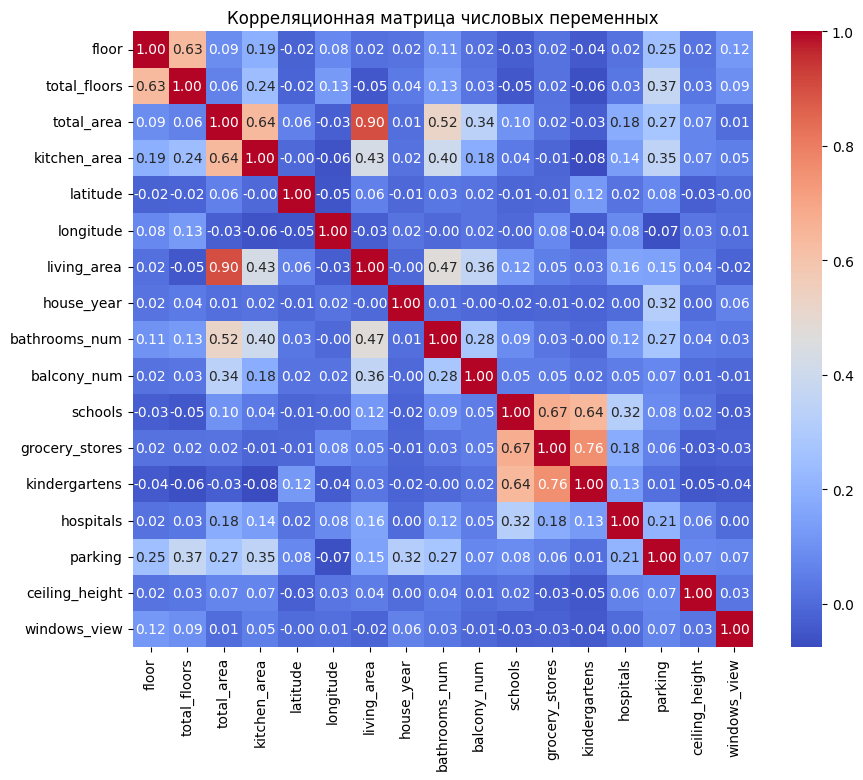

In [8]:
correlation_matrix = df[float_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Корреляционная матрица числовых переменных")
plt.show()

Анализ корреляционной матрицы числовых переменных выявил несколько ключевых взаимосвязей, которые могут влиять на стабильность и эффективность предиктивных моделей. Сильная корреляция между floor и total_floors, а также между living_area, kitchen_area и total_area, указывает на возможное наличие мультиколлинеарности. Это явление может затруднить интерпретацию моделей и привести к переобучению.

In [9]:
df = df.drop(['total_floors', 'kitchen_area', 'living_area'], axis=1)

float_columns.remove('total_floors')
float_columns.remove('kitchen_area')
float_columns.remove('living_area')

### Анализ пропущенных значений

In [10]:
columns_with_miss = df.columns[df.isna().any(axis=0)]
df[columns_with_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32661 entries, 0 to 32660
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   city_district   27758 non-null  object 
 1   road            31631 non-null  object 
 2   house_number    27475 non-null  object 
 3   ceiling_height  15709 non-null  float64
 4   repair          20370 non-null  float64
 5   house_year      25631 non-null  float64
 6   house_type      24174 non-null  float64
 7   windows_view    12649 non-null  float64
 8   bathrooms_num   21997 non-null  float64
 9   parking         8536 non-null   float64
 10  elevators_num   18820 non-null  float64
 11  balcony_num     21451 non-null  float64
 12  schools         31306 non-null  float64
 13  hospitals       24476 non-null  float64
 14  grocery_stores  32303 non-null  float64
 15  kindergartens   31770 non-null  float64
dtypes: float64(13), object(3)
memory usage: 4.0+ MB


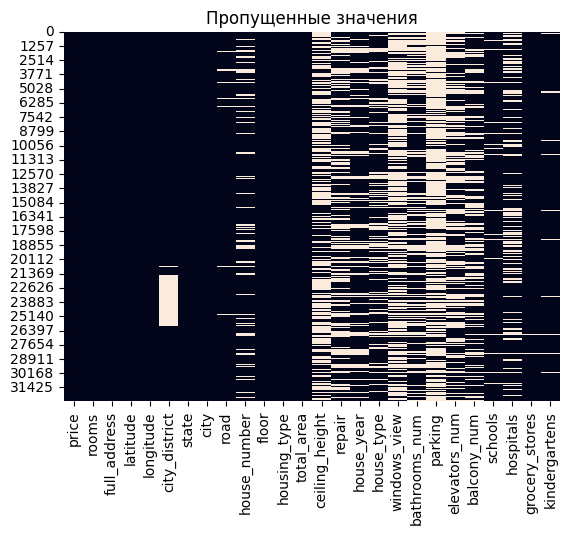

In [11]:
sns.heatmap(df.isnull(), cbar=False)
plt.title("Пропущенные значения")
plt.show()

Парковка, высота потолков и вид из окон имеют очень много пропущенных значений, поэтому было принято решение удалить их из анализа.

In [12]:
df.drop(['parking', 'ceiling_height', 'windows_view'], axis=1, inplace=True)

float_columns.remove('parking')
float_columns.remove('ceiling_height')
float_columns.remove('windows_view')

Можно заметить, что пропущенных значений нет только в столбцах price, rooms, full_address, lattitude, longtitude, state, city, floor, total_floors, housing_type, total_area, schools, hospitals, grocery_stores и kindgardens. Это означает, что для остальных параметров необходимо выполнить заполнение пропущенных значений.


### Обнаружение выбросов и обработка аномальных значений

In [13]:
def plot_boxplots(df, columns, num_cols=4):
    num_rows = len(columns) // num_cols + (len(columns) % num_cols > 0)
    plt.figure(figsize=(num_cols * 5, num_rows * 5))
    for i, column in enumerate(columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.boxplot(x=df[column])
        plt.title(f'Boxplot for {column}')
    plt.tight_layout()
    plt.show()

float_columns_filter = [column for column in float_columns if column not in ['latitude', 'longitude']]

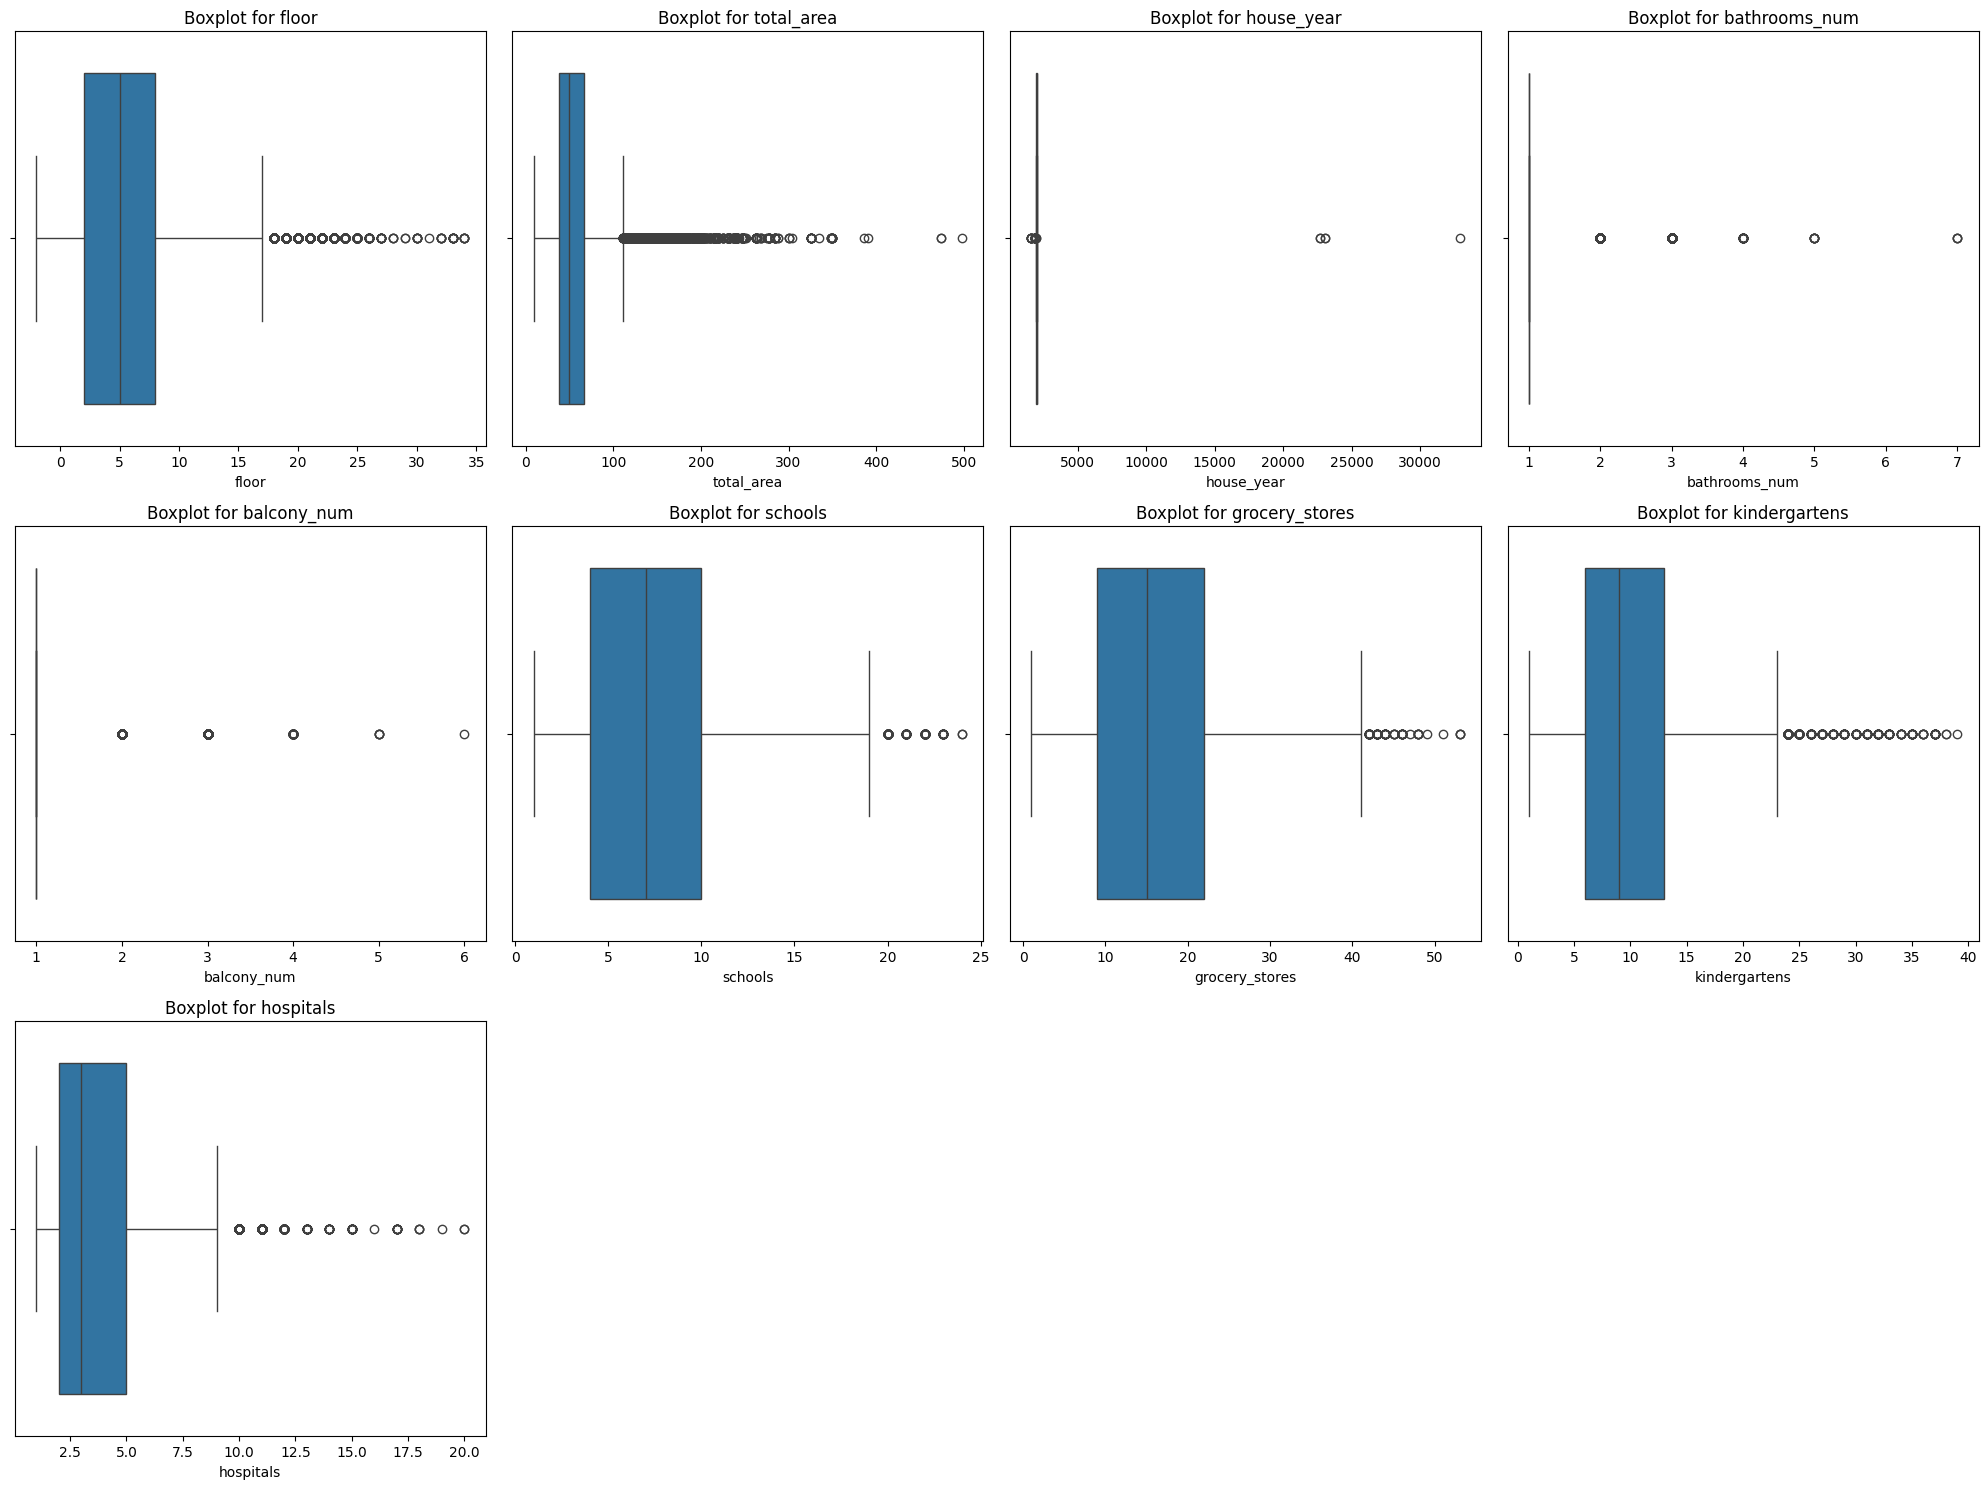

In [14]:
plot_boxplots(df, float_columns_filter)

В данных о годе постройки зданий были обнаружены значения вне реалистического диапазона от 1800 до 2050 года. Для обеспечения точности анализа, значения за пределами этого диапазона были заменены на медианное значение года постройки. Это позволяет исключить потенциальные ошибки ввода и сохранить целостность данных для анализа и моделирования.

In [15]:
median_year = df['house_year'].median()
df['house_year'] = df['house_year'].apply(lambda x: median_year if not 1800 <= x <= 2050 else x)

Также были удалены строки с отрицательными этажами.

In [16]:
df = df[df['floor'] > 0]

При парсинге данных было разработано получение данных об инфраструктуре: количество школ (schools), больниц (hospitals), продуктовых магазинов (grocery_stores), садиков (kindergartens) в радиусе 1000 м. В процессе парсинга данных, если в указанном радиусе отсутствовали какие-либо из этих объектов, то вместо записи числа 0, в данных появлялись пропуски (null). Для корректности последующего анализа и избежания ошибок в обработке данных было принято решение заполнить все такие пропущенные значения нулями.


In [17]:
columns_to_fill = ['schools', 'hospitals', 'grocery_stores', 'kindergartens']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

Для улучшения качества анализа было решено исключить признак, содержащий полный адрес объекта недвижимости, поскольку датасет уже включает разделенные составляющие адреса, такие как город, улица, а также был исключен номер дома, так как такое большое количество категорий может привести к переобучению или значительно увеличить время обучения и потребление памяти.

In [18]:
df = df.drop(columns=['full_address', 'house_number', 'road'])

categorical_columns.remove('full_address')
categorical_columns.remove('house_number')
categorical_columns.remove('road')

Для минимизации влияния экстремальных значений и улучшения стабильности моделей было принято решение ограничить выбросы в ключевых числовых переменных. В основу ограничения положен подход, использующий верхние границы, определённые через 95-й квантиль каждой переменной. Этот метод позволяет удерживать данные в более узком и репрезентативном для большинства наблюдений диапазоне.



In [19]:
def replace_outliers_with_boundaries(df, column, upper_quantile=0.95):
    upper_bound = df[column].quantile(upper_quantile)
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

replace_outliers_with_boundaries(df, 'floor', 0.99)
replace_outliers_with_boundaries(df, 'total_area', 0.95)
replace_outliers_with_boundaries(df, 'schools', 0.95)
replace_outliers_with_boundaries(df, 'grocery_stores', 0.95)
replace_outliers_with_boundaries(df, 'kindergartens', 0.95)
replace_outliers_with_boundaries(df, 'hospitals', 0.95)

df['bathrooms_num'] = np.where(df['bathrooms_num'] > 3, 3, df['bathrooms_num'])
df['balcony_num'] = np.where(df['balcony_num'] > 2, 2, df['balcony_num'])

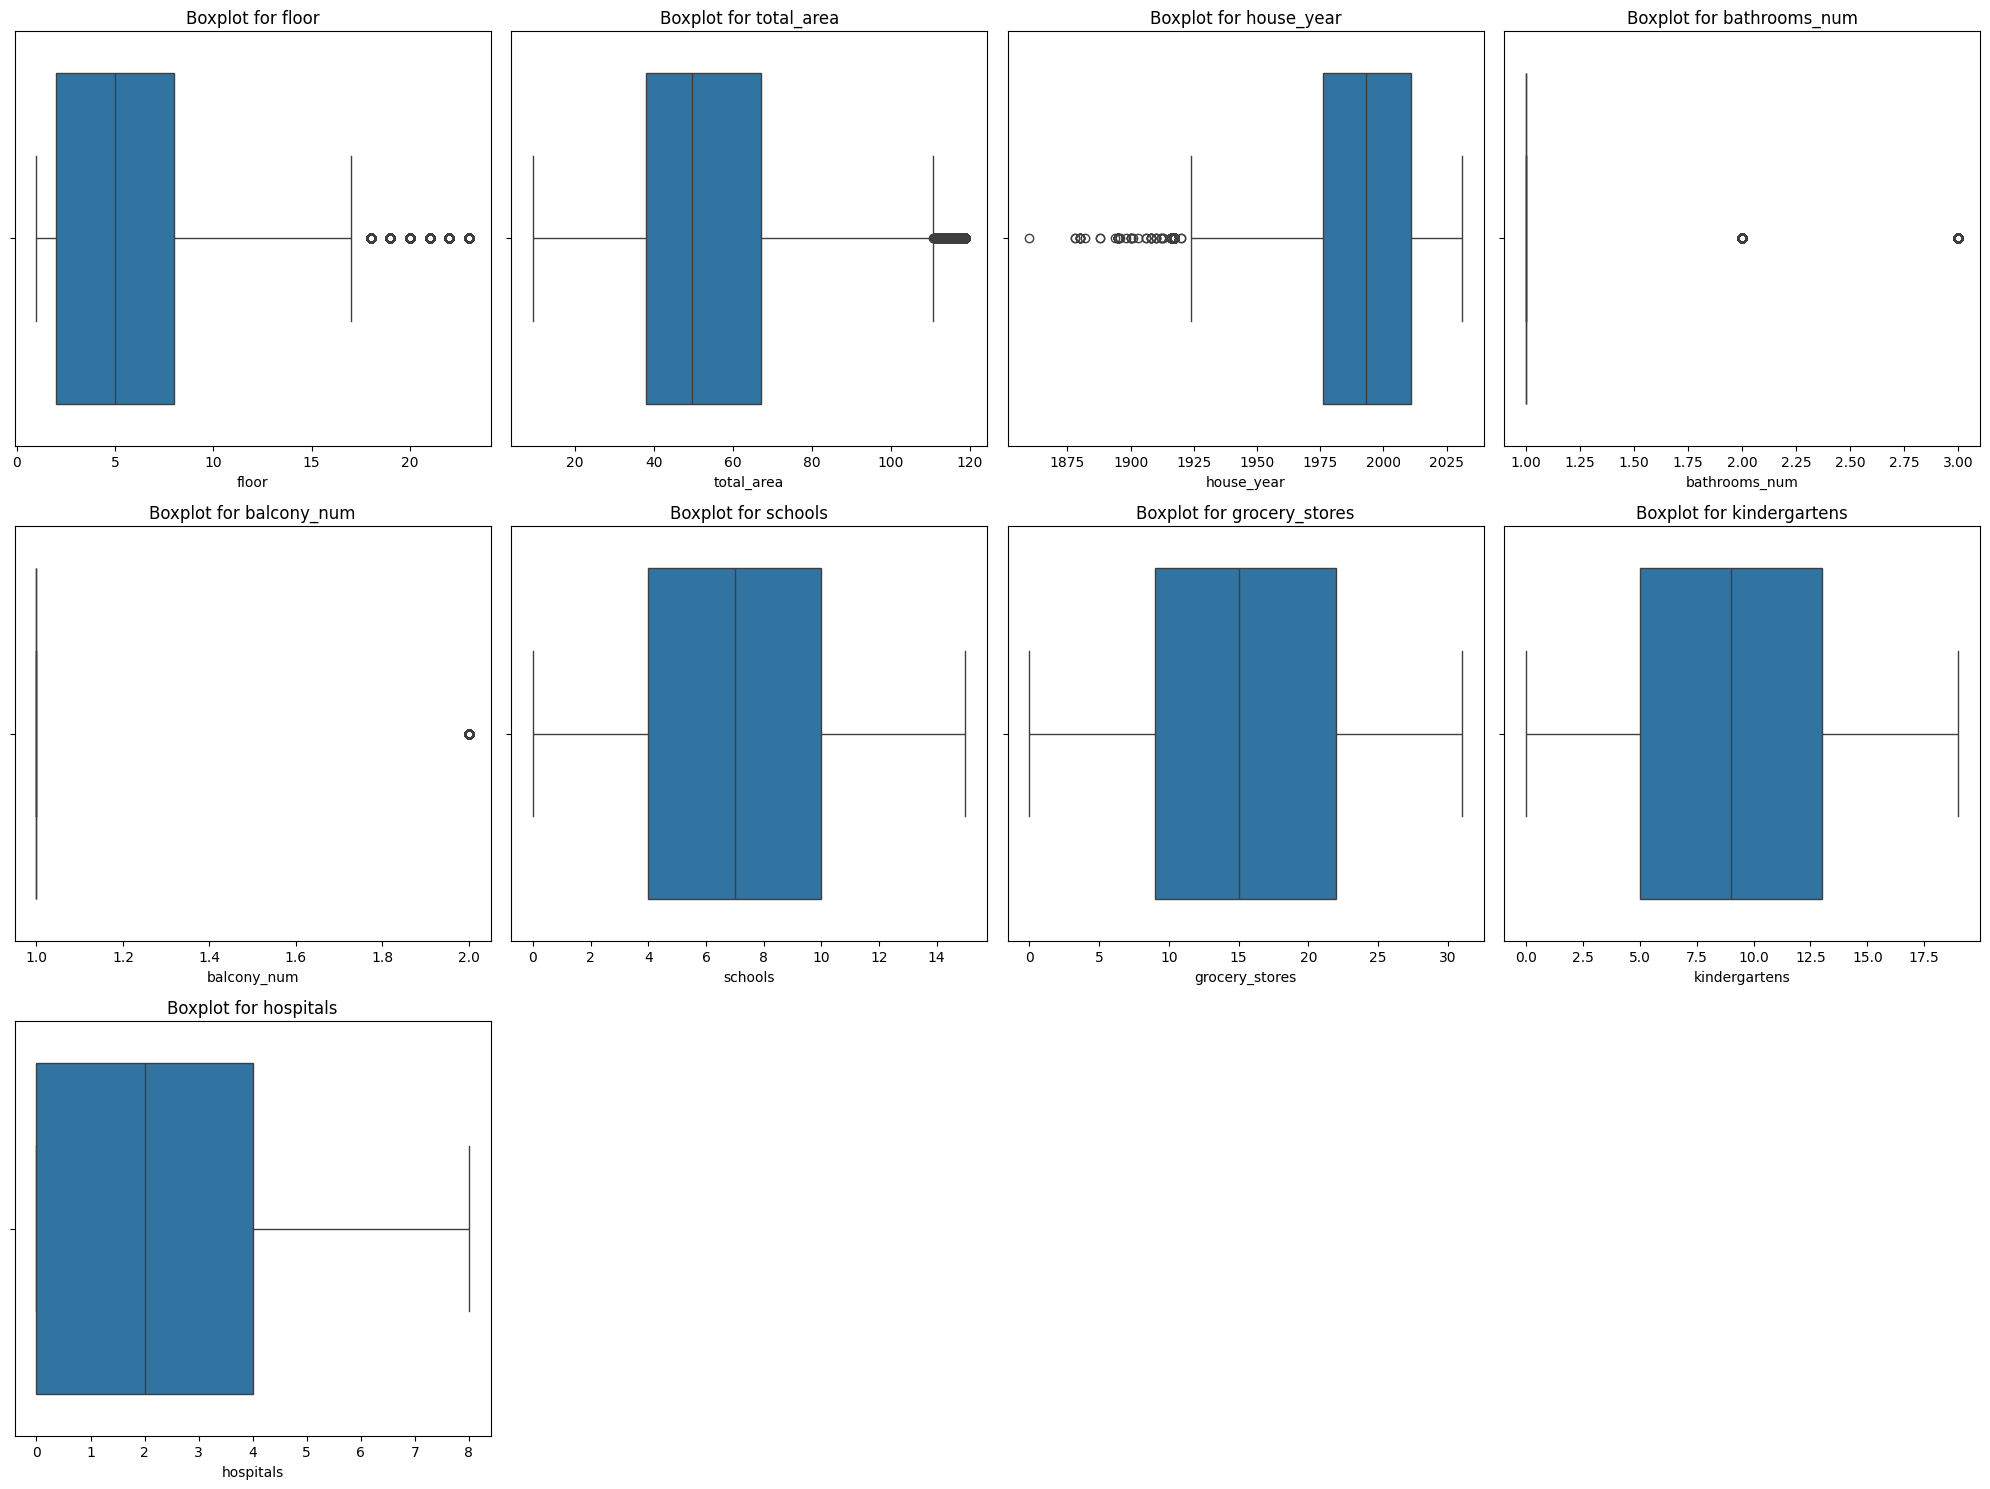

In [20]:
plot_boxplots(df, float_columns_filter)

Анализ графиков до и после обработки аномальных значений показывает, что примененные методы ограничения выбросов эффективно снижают количество аномалий в данных. Обработка значительно улучшила распределение ключевых переменных, таких как этаж, общее количество этажей, общая и жилая площади, при этом удалось устранить нереалистичные значения в годе постройки. Количество выбросов для переменных, связанных с количеством ванных комнат, балконов, а также доступностью образовательных и медицинских учреждений, теперь находится на управляемом уровне. Эти изменения способствуют повышению точности и надежности аналитических выводов, делая данные более подходящими для последующего анализа и моделирования.

### Распределение признаков

#### Распределение числовых признаков

Анализ распределения числовых признаков выявил несколько важных особенностей и аномалий, которые требуют внимания при подготовке данных для моделирования. Рассмотрим каждый признак с точки зрения дальнейших действий для улучшения качества данных и их применения в обучении моделей машинного обучения.

In [21]:
def plot_histograms(df, columns, num_cols=4):
    num_rows = len(columns) // num_cols + (len(columns) % num_cols > 0)
    plt.figure(figsize=(num_cols * 5, num_rows * 5))
    for i, column in enumerate(columns):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(df[column].dropna(), kde=True)
    plt.tight_layout()
    plt.show()

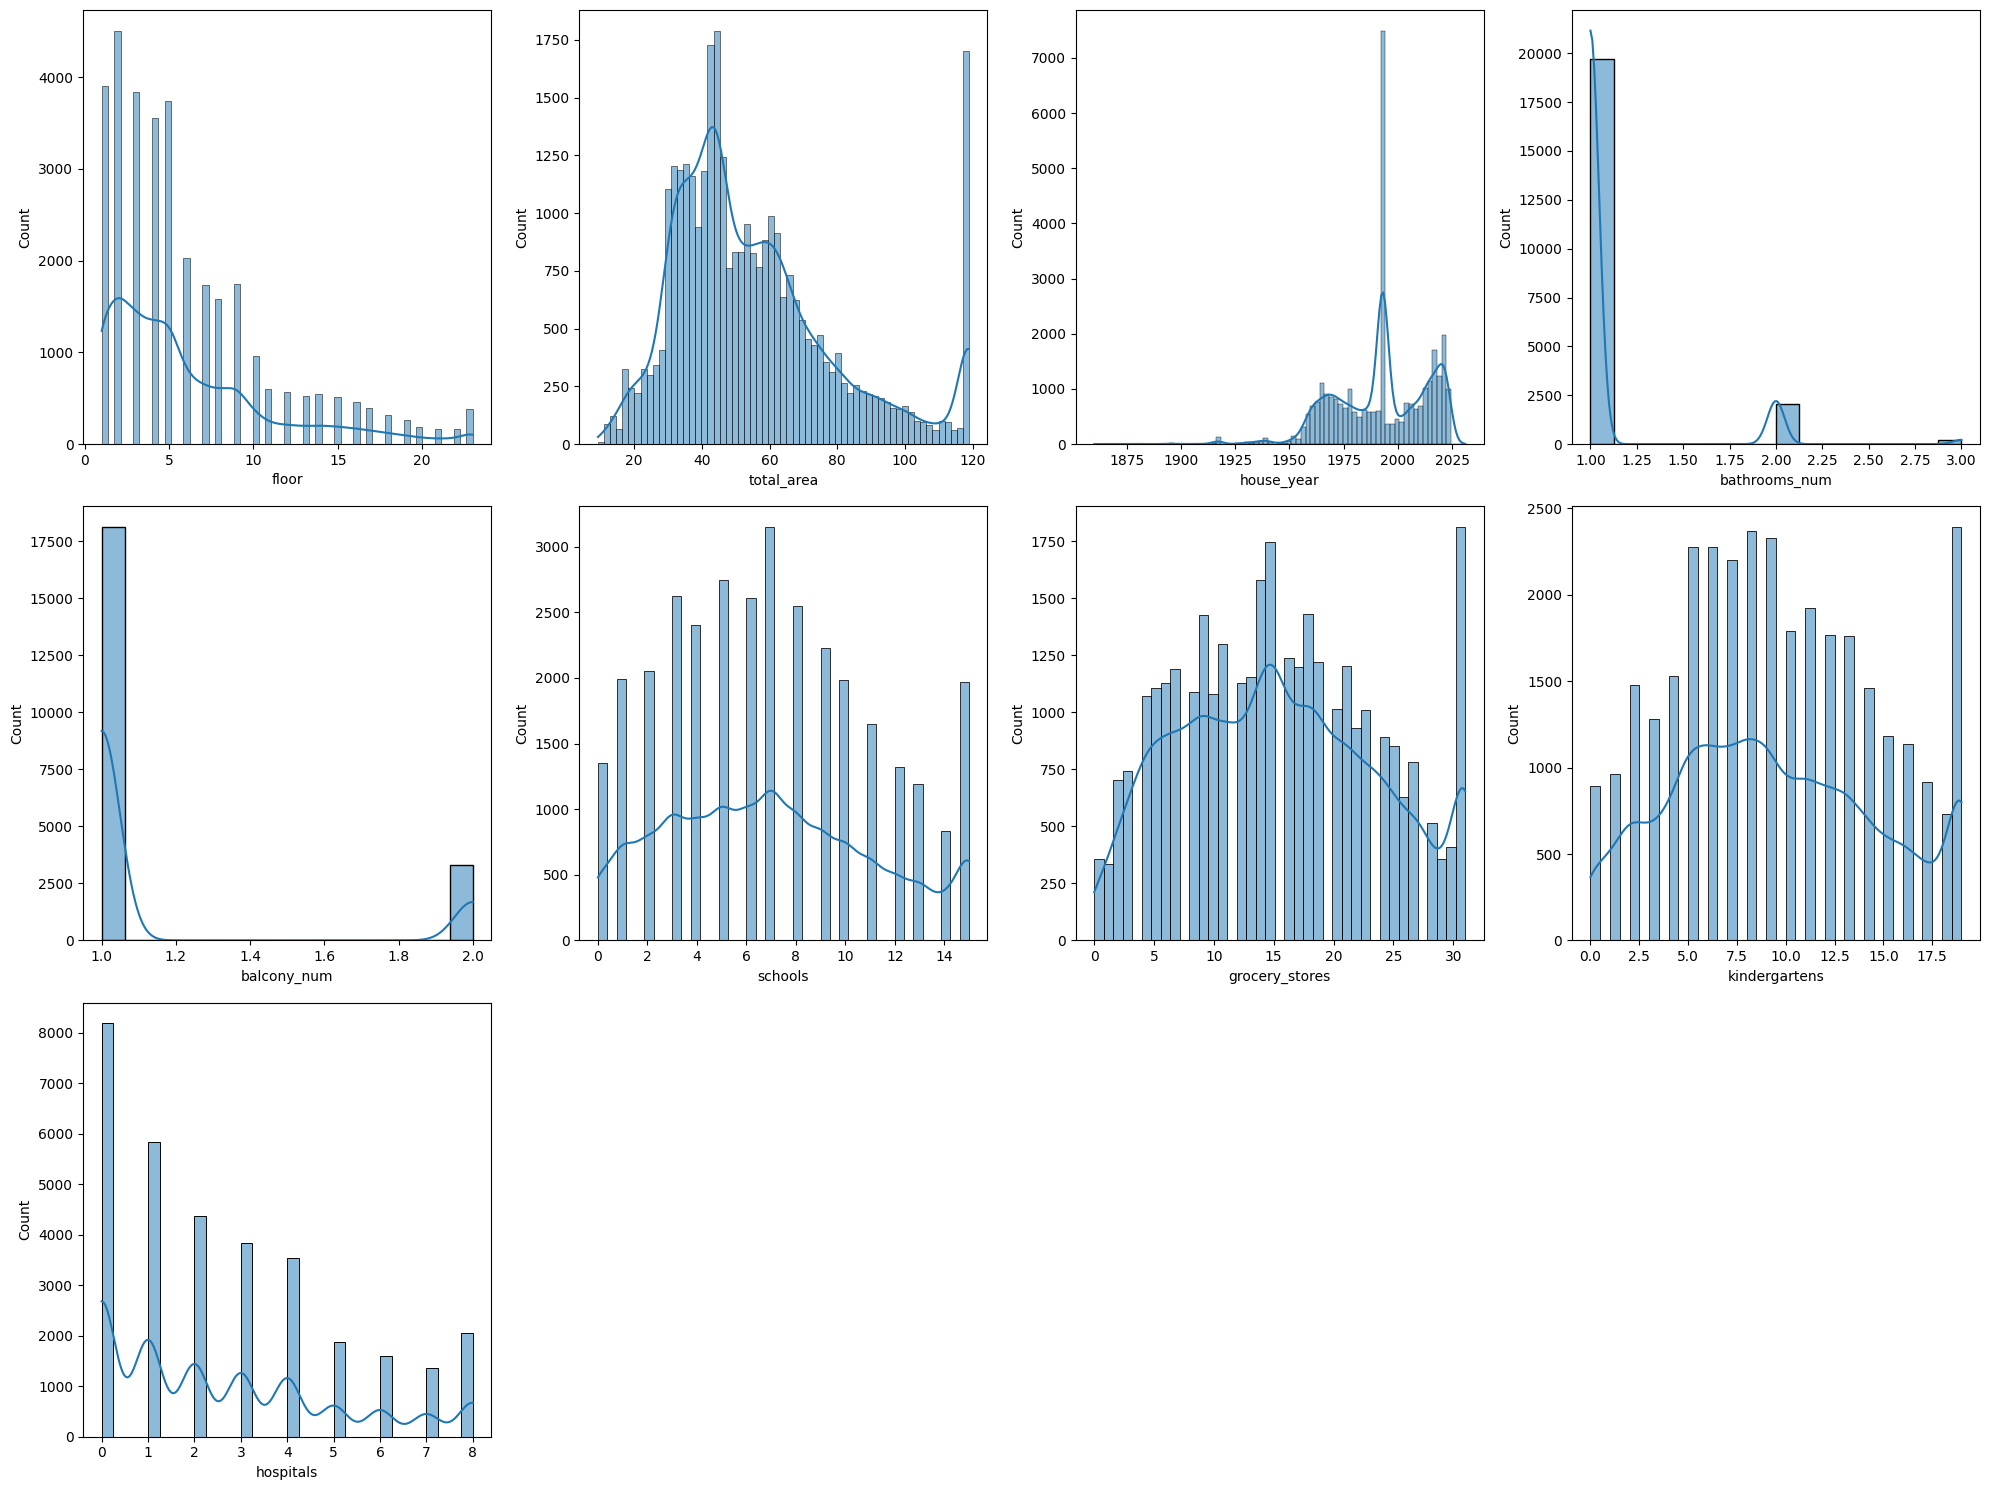

In [22]:
plot_histograms(df, float_columns_filter)

* floor: распределение имеет правую асимметрию с длинным хвостом, что может указывать на наличие выбросов. Можно рассмотреть логарифмическое преобразование для уменьшения влияния выбросов. Также можно установить верхний предел для значений этажей, чтобы исключить экстремальные значения.
* total_area: наличие нескольких пиков и значительное количество выбросов. Можно применить логарифмическое или Box-Cox преобразование для нормализации распределения. Выбросы могут быть обработаны путем ограничения верхнего предела или использования методов устойчивой регрессии.
* house_year: скопление данных в последние десятилетия.
Рекомендации: Заменить нереалистичные значения медианой или модой распределения. Возможно, стоит создать категориальный признак для группировки по периодам строительства (например, до 1950, 1950-2000, после 2000).
* bathrooms_num: большинство объектов имеют одну или две ванные комнаты, но есть выбросы.
* balcony_num: большинство объектов имеют один или два балкона, но есть выбросы.
* schools: близкое к нормальному распределение с несколькими пиками. Можно применить стандартизацию или нормализацию. Возможно, стоит создать категориальные признаки на основе количества школ (например, низкая, средняя, высокая доступность).
* grocery_stores: наличие нескольких пиков, что указывает на различие в инфраструктуре. Возможно, стоит создать категориальные признаки
* kindergartens: распределение с несколькими пиками.
* hospitals: большинство объектов имеют доступ к небольшому количеству больниц, есть выбросы.

Преобразование года постройки в категориальные признаки:

In [23]:
bins = [1800, 1970, 1990, 2010, 2020, 2050]
labels = ['До 1970', '1970-1990', '1990-2010', '2010-2020', 'После 2020']
df['house_year_category'] = pd.cut(df['house_year'], bins=bins, labels=labels, right=False)

categorical_columns.append('house_year_category')

#### Распределение категориальных признаков

Для визуализации распределения категориальных признаков была исключена улица, так как количество уникальных значений в этих признаках слишком велико.

In [24]:
def plot_countplots(df, columns, num_cols=2):
    num_rows = len(columns) // num_cols + (len(columns) % num_cols > 0)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 10, num_rows * 6))
    axs = axs.flatten()
    for i, column in enumerate(columns):
        sns.countplot(y=df[column], order=df[column].value_counts().index, ax=axs[i])
        axs[i].set_title(f'{column}')
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)
    plt.tight_layout()
    plt.show()

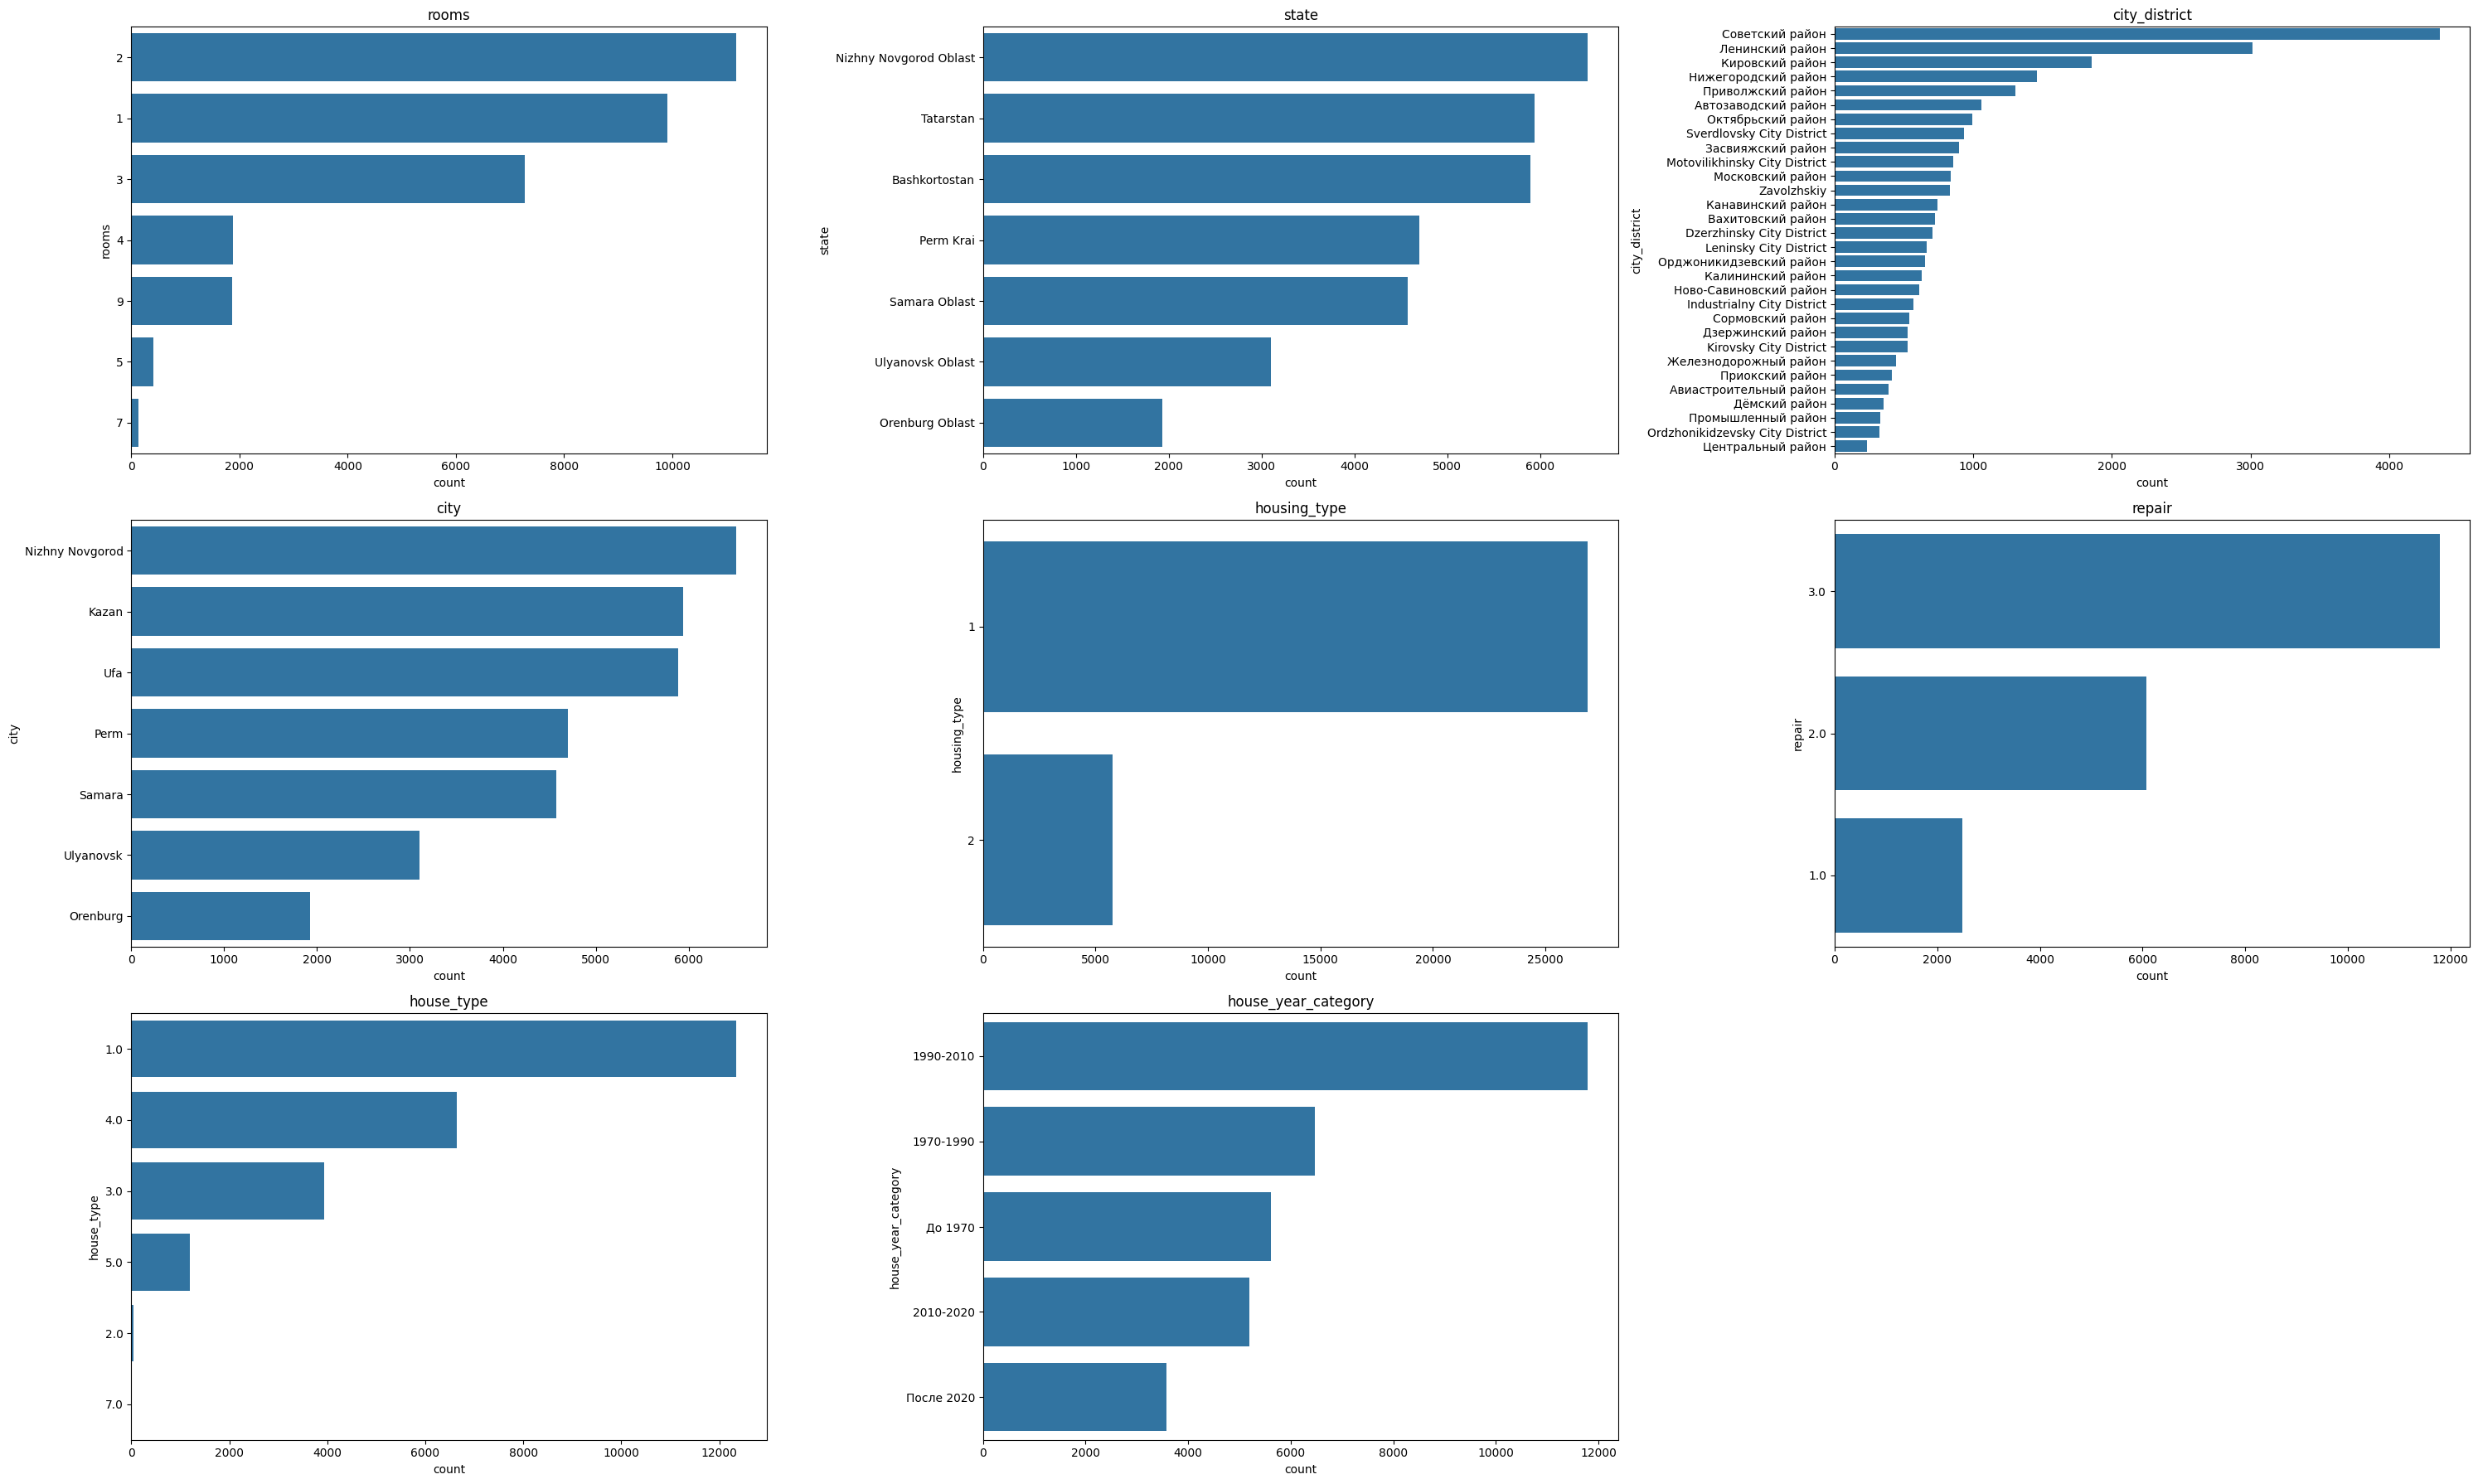

In [25]:
plot_countplots(df, categorical_columns, num_cols=3)

#### Предобработка категориальных признаков

На основании предоставленных гистограмм категориальных признаков можно сделать следующие наблюдения и выводы:
* Комнаты (rooms) - большинство объектов недвижимости имеют от 1 до 2 комнат, что указывает на высокий спрос или предложение малогабаритных квартир. Распределение сильно смещено в сторону этих категорий.
* Субъект РФ (state) - наблюдается доминирование определенных регионов, таких как Татарстан и Башкортостан, что может свидетельствовать о более высоком объеме данных или более активном рынке недвижимости в этих регионах.
* Город (city) - Нижний Новгород и Казань выделяются среди других городов по количеству объектов недвижимости в датасете. Это может указывать на более крупные рынки недвижимости в этих городах.
* Район (city_district) - отдельные районы Нижнего Новгорода значительно доминируют в выборке.
* Тип жилья (housing_type) - очевидное преобладание вторичного типа жилья в выборке, что может ограничивать возможность анализа влияния этого признака на стоимость жилья.
* Ремонт (repair) - распределение показывает, что большинство объектов косметический ремонт, с небольшим количеством объектов в других категориях. Это может влиять на анализ влияния состояния жилья на его стоимость.
* Тип дома (house_type) - подавляющее большинство объектов принадлежат к кирпичным домам, что также может указывать на ограниченное влияние этого признака на изменение стоимости недвижимости в анализе.

Преобразование и фильтрация данных в колонке rooms проводится следующим образом:
*   1-комнатные, 2-комнатные, 3-комнатные сохраняются без
изменений, так как эти категории представлены достаточно большим количеством наблюдений и являются стандартными категориями для анализа рынка недвижимости.
*   4-комнатные и 5-комнатные объединяются в одну категорию "4+ комнатные". Это решение основано на том, что количество данных для 5-комнатных квартир мало, и объединение их с 4-комнатными может помочь улучшить статистическую значимость и упростить модель, снижая риск переобучения.
*   Категория 7 (свободной планировки) исключается из анализа, так как она может иметь специфические особенности, которые отличают её от других типов жилья и требуют отдельного анализа, а также данных для этой категории мало.
*   Категория 9 (студия) сохраняется отдельно и преобразуется в "0", так как студии представляют собой уникальный сегмент рынка недвижимости и могут иметь другую ценовую динамику по сравнению с квартирами с раздельными комнатами.

In [26]:
df.loc[df['rooms'].isin([4, 5]), 'rooms'] = 4
df = df[df['rooms'] != 7]
df.loc[df['rooms'] == 9, 'rooms'] = 0
print(df['rooms'].value_counts())

rooms
2    11184
1     9910
3     7268
4     2300
0     1858
Name: count, dtype: int64


В процессе предварительной обработки данных столбца house_type было принято решение исключить категории 2 (деревянный) и 7 (сталинский), заменяя их на None. Это решение основывается на том, что указанные категории встречаются довольно редко, что может привести к недостаточной обученности модели и, как следствие, к нестабильности предсказаний для данных типов домов. Удаление этих категорий также помогает упростить аналитическую модель, сокращая количество категорий и минимизируя риск переобучения. Такой подход позволяет сосредоточиться на более общих и часто встречающихся данных, обеспечивая лучшую обобщаемость и точность модели. В дальнейшем, это дает возможность применить более сложные методы для заполнения пропусков, которые могут учитывать дополнительные аспекты данных для более точного предсказания характеристик жилья.

In [27]:
df.loc[df['house_type'].isin([2, 7]), 'house_type'] = None
print(df['house_type'].value_counts())

house_type
1.0    12305
4.0     6640
3.0     3871
5.0     1197
Name: count, dtype: int64


В разделе обработки данных для колонки city_district, где представлены различные районы, мы сталкиваемся с проблемой большого количества уникальных значений. Некоторые районы встречаются довольно редко, что может затруднить аналитическую обработку и повлиять на точность моделей машинного обучения из-за ограниченного количества данных для обучения.

Для упрощения анализа и улучшения статистической значимости данных, предлагается агрегировать наименее представленные районы в одну категорию "Другие". Это сократит количество категорий, уменьшит размерность данных и поможет модели лучше обобщать информацию, уменьшая влияние шума от редко встречающихся районов.

In [28]:
threshold = 500
small_districts = df['city_district'].value_counts()[df['city_district'].value_counts() < threshold].index
df.loc[df['city_district'].isin(small_districts), 'city_district'] = 'Другие'

print(df['city_district'].value_counts())

city_district
Советский район                  4352
Ленинский район                  3006
Другие                           2458
Кировский район                  1852
Нижегородский район              1408
Приволжский район                1298
Автозаводский район              1059
Октябрьский район                 989
Sverdlovsky City District         929
Засвияжский район                 895
Motovilikhinsky City District     854
Московский район                  836
Zavolzhskiy                       826
Канавинский район                 738
Вахитовский район                 714
Dzerzhinsky City District         704
Leninsky City District            654
Орджоникидзевский район           652
Калининский район                 628
Ново-Савиновский район            609
Industrialny City District        571
Сормовский район                  538
Дзержинский район                 527
Kirovsky City District            521
Name: count, dtype: int64


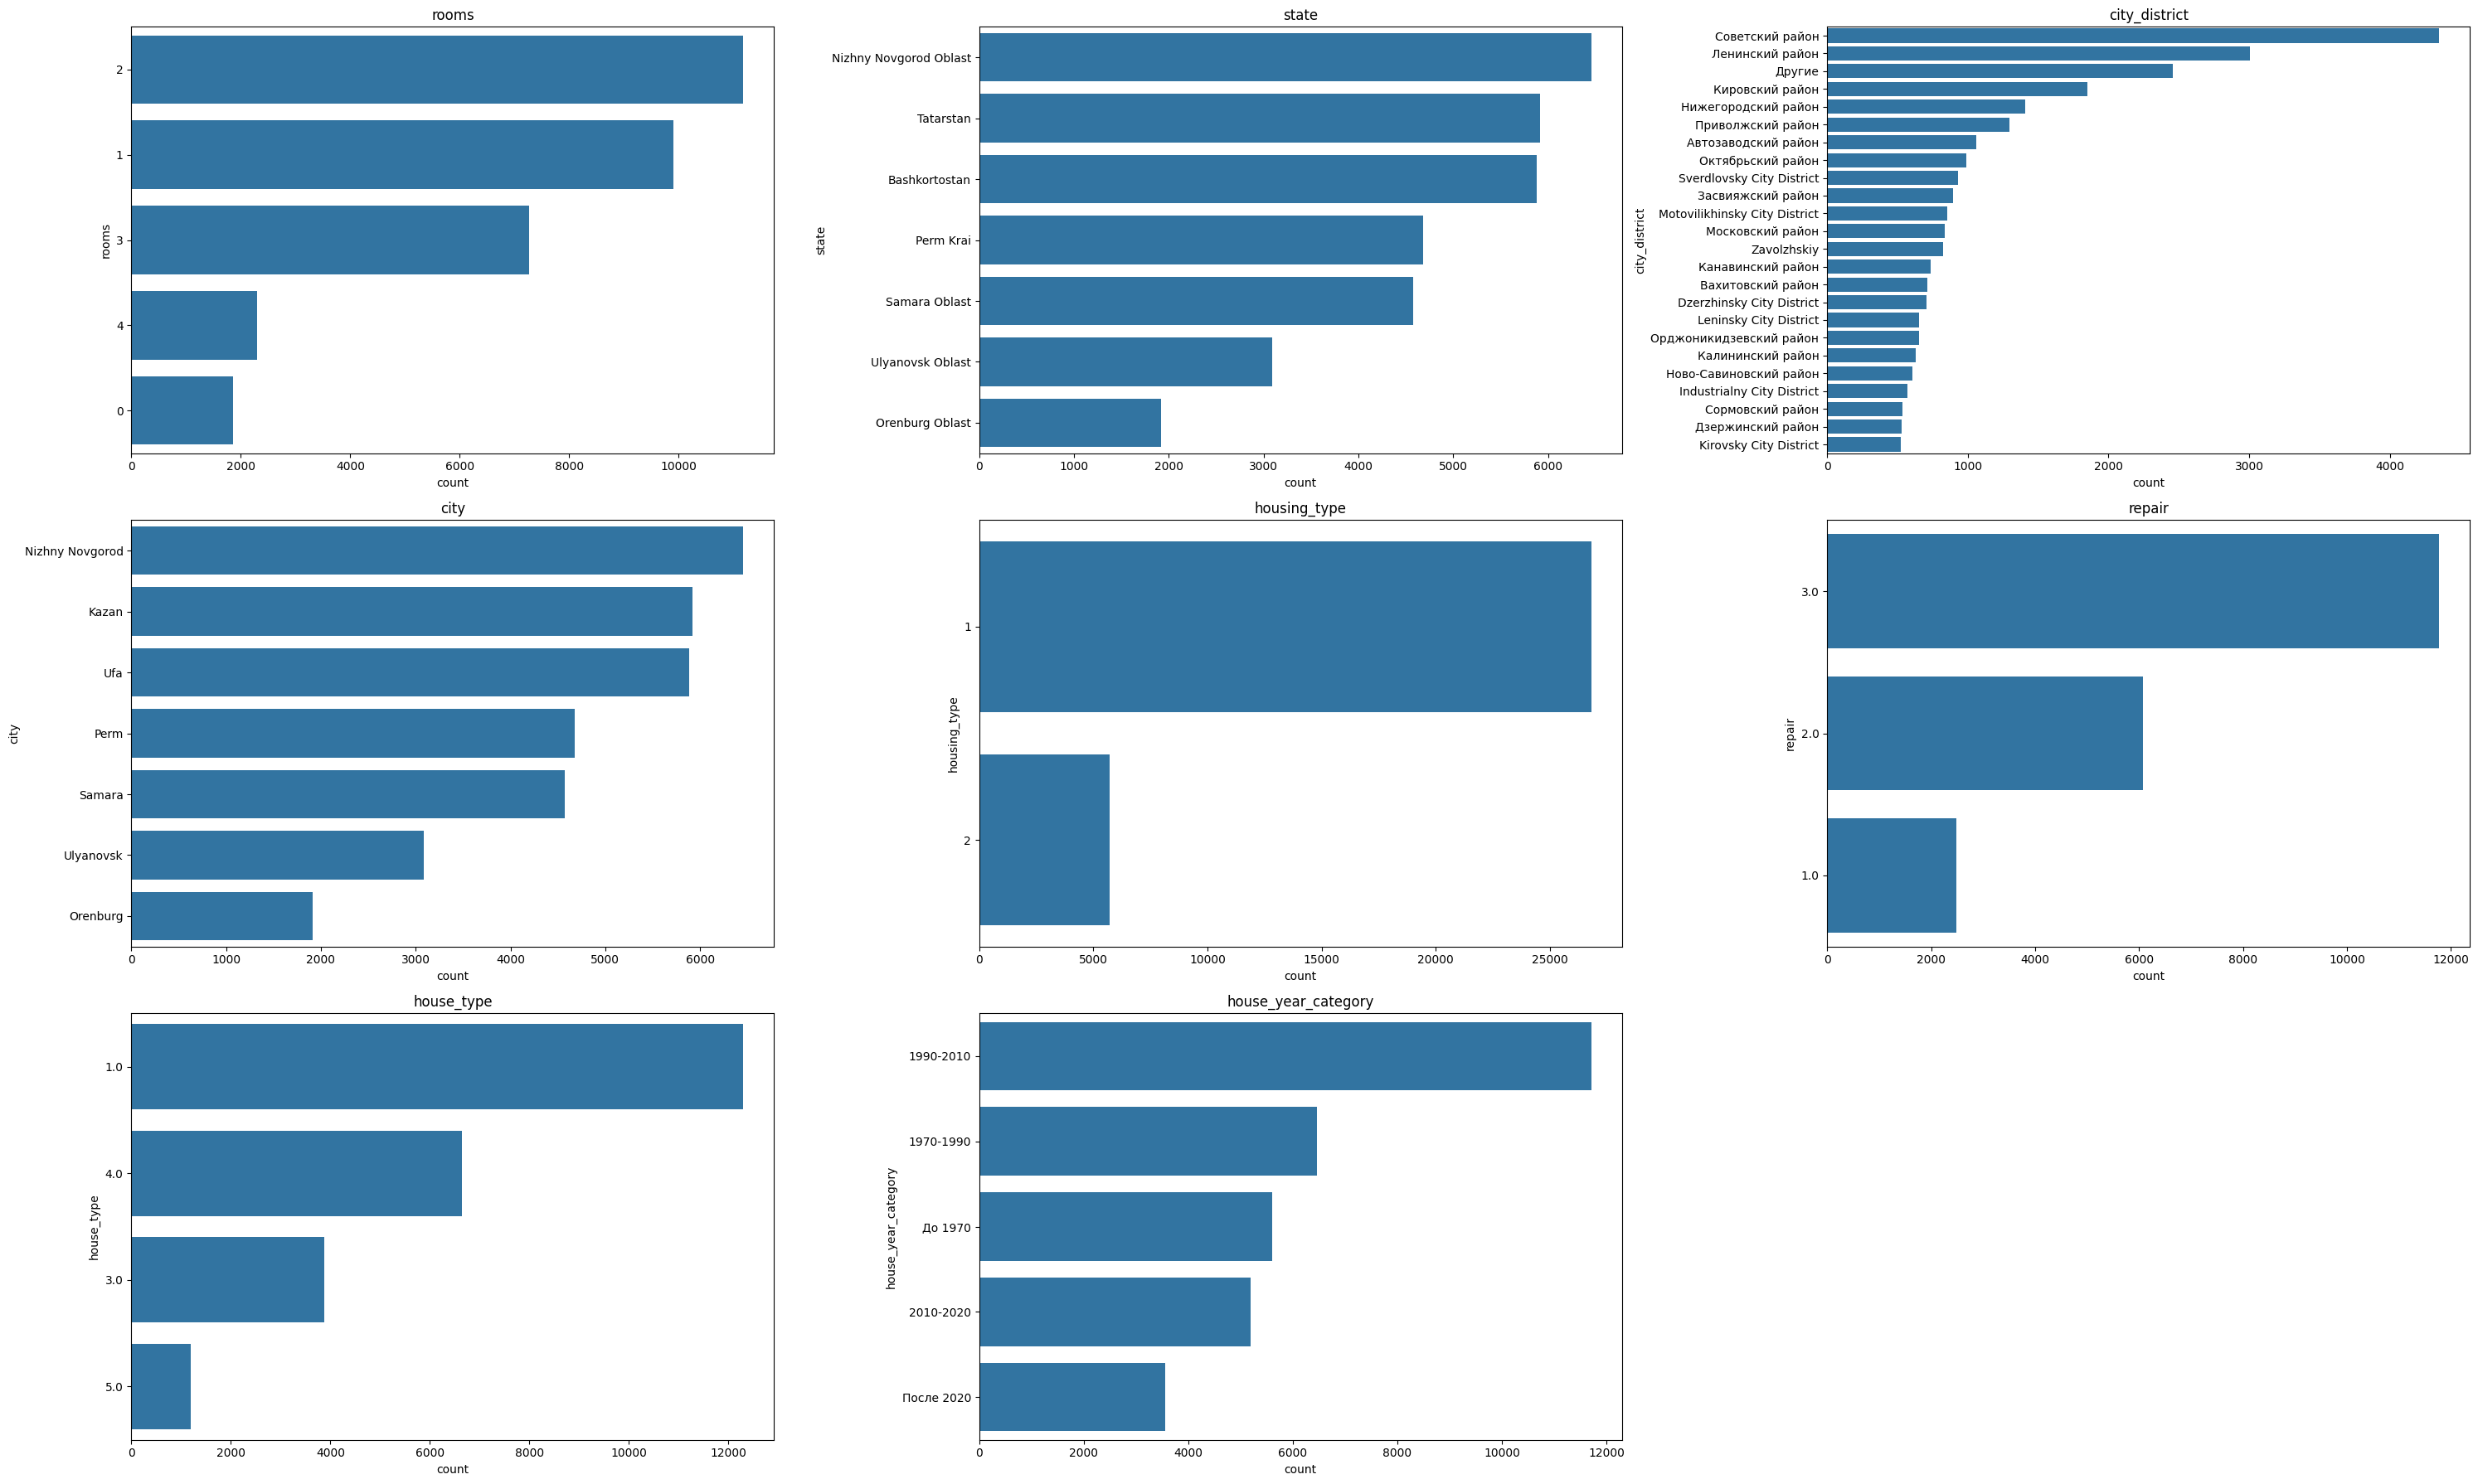

In [29]:
plot_countplots(df, categorical_columns, num_cols=3)

#### Распределение целевой переменной

На графике распределения цен видно, что данные сильно скошены вправо, что может негативно сказаться на производительности моделей машинного обучения. Для улучшения аналитических свойств распределения необходимо применить преобразование.

<Axes: xlabel='price', ylabel='Count'>

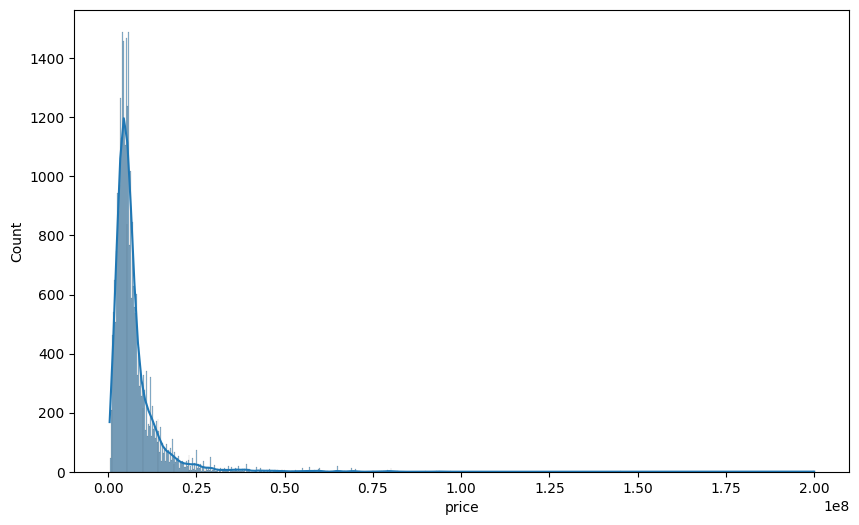

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df[target_name], kde=True, ax=ax)

### Взаимосвязь между числовыми признаками и целевой переменной

Используя scatter plot и KDE plot, мы можем увидеть точечное распределение значений и понять плотность распределения данных в двухмерном пространстве. Это позволяет выявить потенциальные тренды, зависимости и аномалии, которые могут повлиять на модель машинного обучения. Scatter plot помогает визуально оценить наличие линейных или нелинейных зависимостей между признаками и целевой переменной. Это особенно важно для выбора признаков и дальнейшего моделирования. KDE plot помогает понять распределение данных в двухмерном пространстве и выявить области с высокой плотностью. Это полезно для выявления скрытых зависимостей и аномалий.

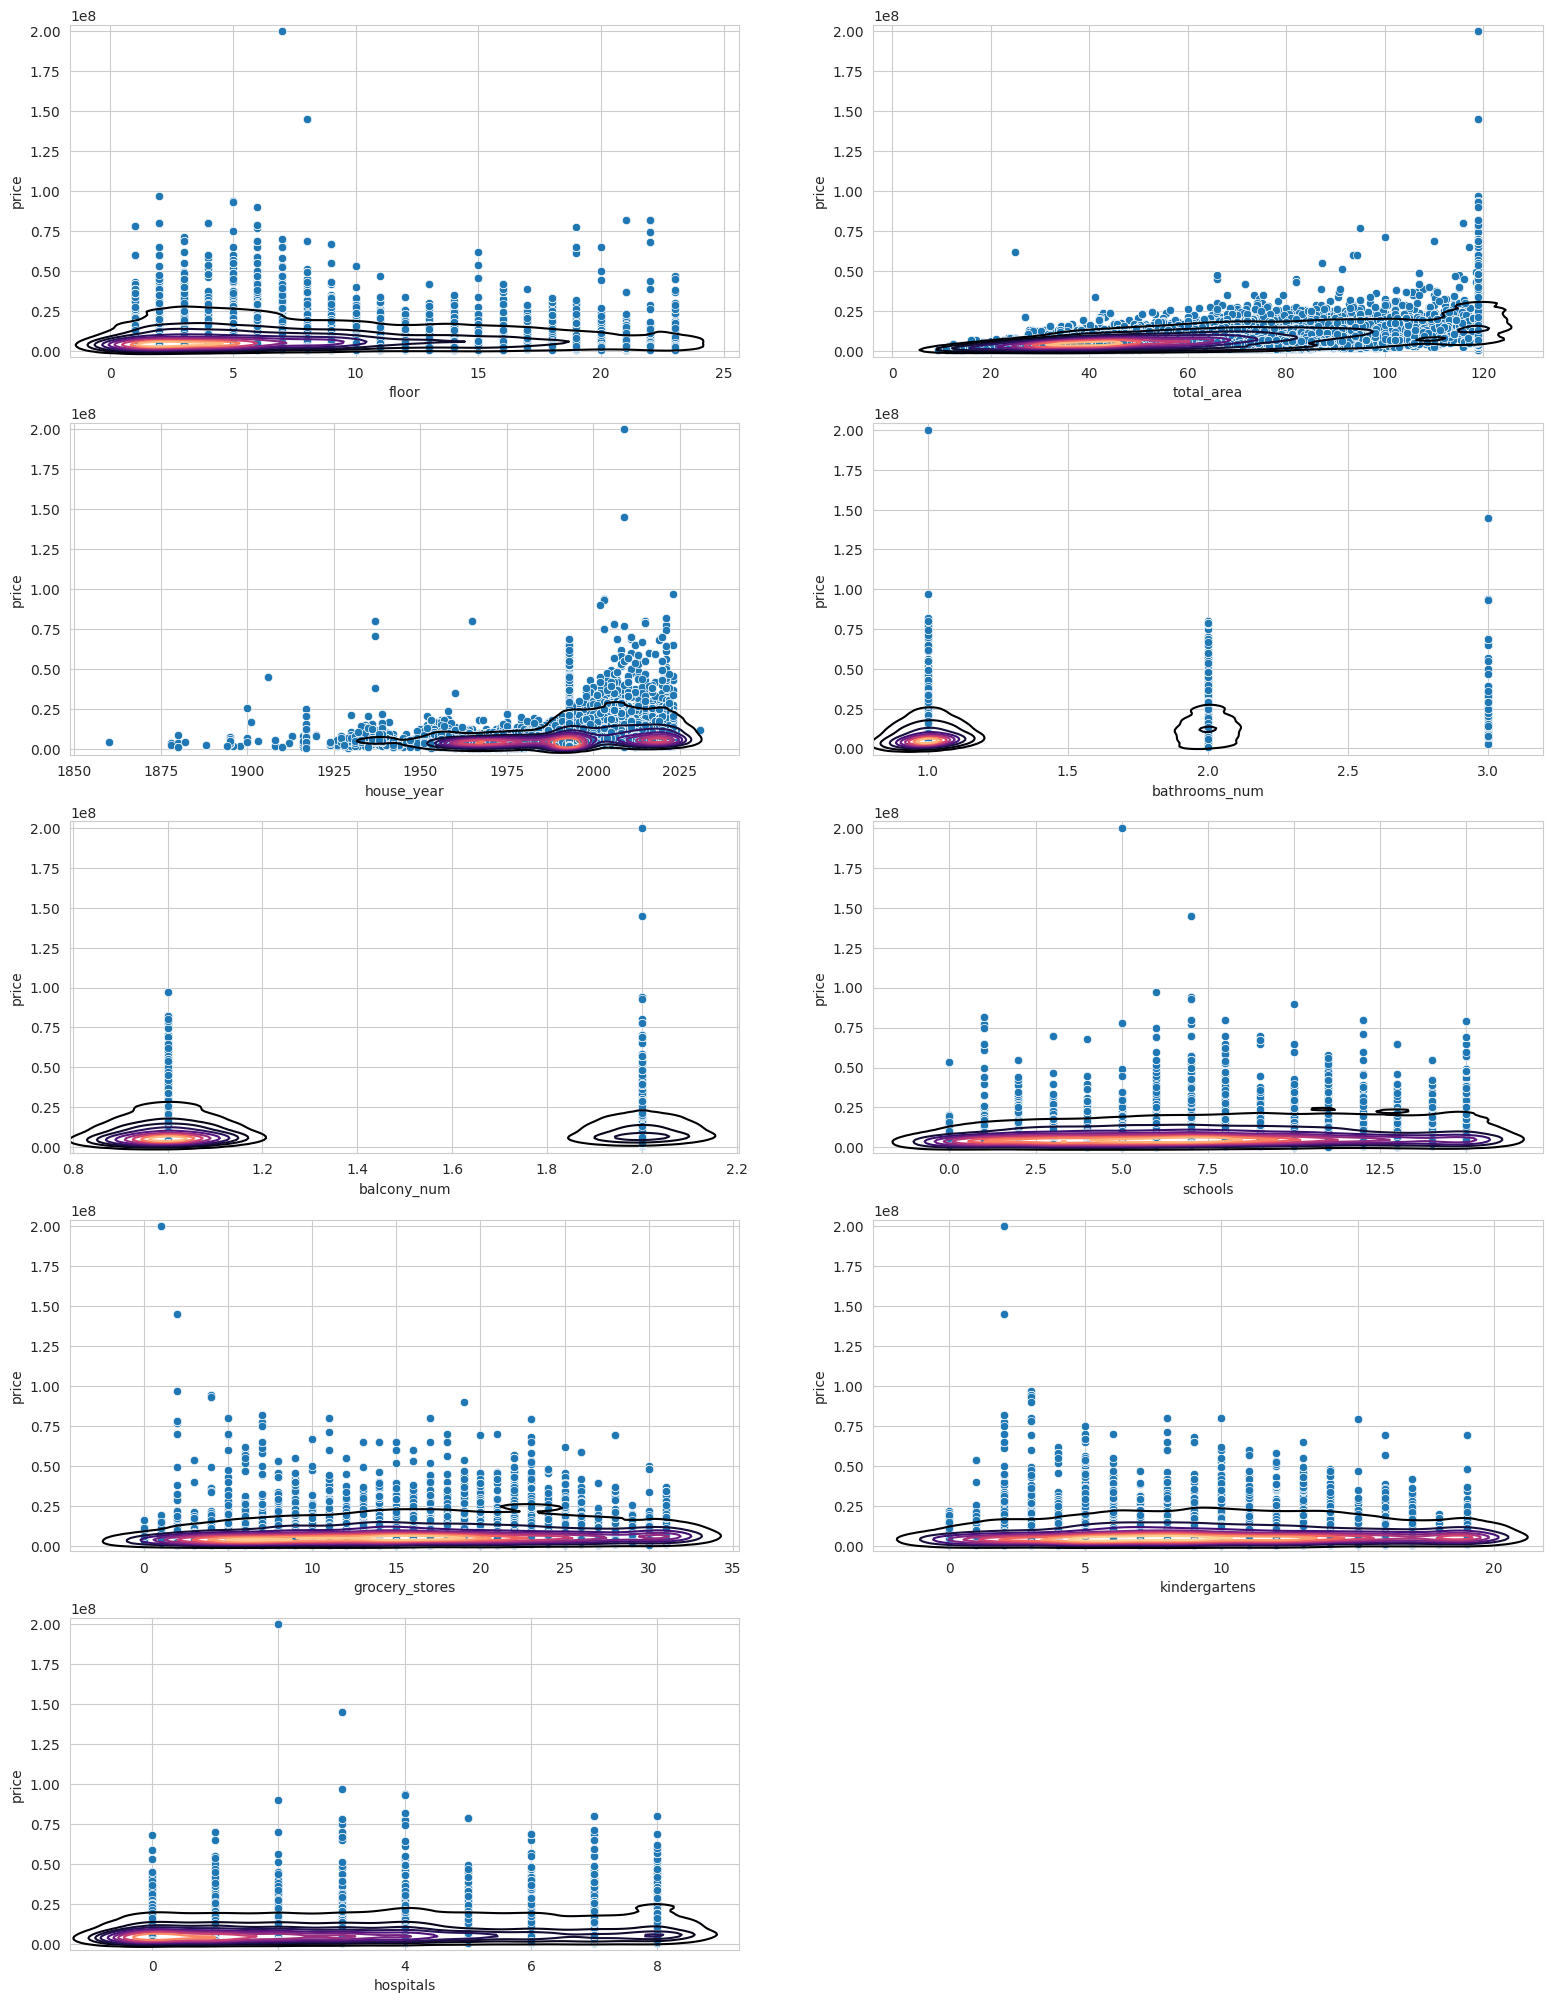

In [31]:
with sns.plotting_context(font_scale=1.5), sns.axes_style("whitegrid"):
    n = len(float_columns_filter)
    plt.figure(figsize=(19, 5*(n+1)//2))
    for i, col in enumerate(float_columns_filter):
        plt.subplot((n+1)//2, 2, i+1)
        sns.scatterplot(x = col, y = target_name, data = df, )
        sns.kdeplot(x = col, y = target_name, data = df, cmap = 'magma')

* floor. На графике видно, что большинство объектов сосредоточено на низких этажах (1-10). Незначительное количество объектов на высоких этажах свидетельствует о низкой плотности данных на высоких этажах. Поэтому лучше оставить этот признак для модели, так как этаж может оказывать влияние на стоимость жилья.
* total_area. На графике видно, что наблюдается положительная зависимость между общей площадью и стоимостью жилья. С увеличением площади стоимость жилья растет, но есть выбросы для больших площадей. Поэтому лучше сохранить этот признак для модели, так как площадь жилья является значимым фактором, влияющим на его стоимость.
* house_year. На графике видно, что большая часть объектов построена в последние годы, что может свидетельствовать о новостройках. Есть выбросы для старых домов, которые могут влиять на модель. Поэтому лучше преобразовать этот признак в категориальный, как было сделано ранее, так как разные периоды строительства могут иметь разное влияние на стоимость.
* bathrooms_number. На графике видно, что большинство объектов имеет одну ванную комнату. Есть несколько выбросов для объектов с большим количеством ванных комнат.
* balcony_number. На графике видно, что большинство объектов имеют один балкон. Есть небольшое количество объектов с двумя балконами и крайне редкие случаи с большим количеством балконов. Поэтому лучше оставить этот признак, но следует рассмотреть возможность объединения редких категорий или ограничения верхнего значения.
* grocery_stores. На графике видно, что данные распределены равномерно, но наблюдается высокая плотность данных в определенных областях. Не наблюдается явной зависимости между количеством магазинов и стоимостью жилья. Поэтому лучше оставить этот признак в модели для проверки его значимости.
* schools. На графике видно, что данные распределены равномерно с высокой плотностью в некоторых областях. Не наблюдается явной зависимости между количеством школ и стоимостью жилья. Поэтому лучше оставить этот признак в модели для проверки его значимости.
* kindergartens. На графике видно, что данные распределены равномерно с высокой плотностью в некоторых областях. Не наблюдается явной зависимости между количеством детских садов и стоимостью жилья. Поэтому лучше оставить этот признак в модели для проверки его значимости.
* hospitals. На графике видно, что данные распределены равномерно с высокой плотностью в некоторых областях. Не наблюдается явной зависимости между количеством больниц и стоимостью жилья. Поэтому лучше оставить этот признак в модели для проверки его значимости.

### Корреляция Спирмана

В анализе была использована корреляция Спирмена для оценки степени монотонной связи между числовыми переменными и ценой жилья. Корреляция Спирмена является непараметрическим методом, который оценивает степень ассоциации между переменными, основываясь на рангах значений данных, а не на их фактических значениях. Этот метод подходит для использования с данными, которые не обязательно распределены нормально и когда взаимосвязь между переменными не обязательно линейна.

In [31]:
for float_cat in float_columns:
    print(
        float_cat,
        scipy.stats.spearmanr(
            df.loc[~df[float_cat].isna(), target_name],
            df.loc[~df[float_cat].isna(), float_cat],
        ),
    )

floor SignificanceResult(statistic=0.20963652191714888, pvalue=0.0)
total_area SignificanceResult(statistic=0.5900156084544824, pvalue=0.0)
latitude SignificanceResult(statistic=0.1101825322913229, pvalue=2.2585934519491949e-88)
longitude SignificanceResult(statistic=-0.12644443862882118, pvalue=5.434593674448418e-116)
house_year SignificanceResult(statistic=0.3735381265214156, pvalue=0.0)
bathrooms_num SignificanceResult(statistic=0.30407186993471785, pvalue=0.0)
balcony_num SignificanceResult(statistic=0.2356071361222597, pvalue=1.1140517438917308e-267)
schools SignificanceResult(statistic=0.15925882837757865, pvalue=1.089349634883584e-183)
grocery_stores SignificanceResult(statistic=0.1976251356206184, pvalue=1.096542007849211e-283)
kindergartens SignificanceResult(statistic=0.12492727394553194, pvalue=2.996109569717373e-113)
hospitals SignificanceResult(statistic=0.20654850086487023, pvalue=2.94539070733314e-310)


Анализ корреляции Спирмена с целевой переменной (стоимостью жилья) показал значимые зависимости для всех исследуемых числовых признаков. Признак "floor" имеет статистически значимую корреляцию с ценой (статистика = 0.2096, p-value = 0.0), что свидетельствует о некотором влиянии этажа на стоимость жилья. "Total area" продемонстрировала высокую положительную корреляцию (статистика = 0.5900, p-value = 0.0), подтверждая, что увеличение площади приводит к росту цены. "Latitude" и "longitude" также имеют значимые корреляции, но в разных направлениях (статистика = 0.1102 и -0.1264 соответственно), указывая на географические факторы, влияющие на стоимость. "House year" показал положительную корреляцию (статистика = 0.3735, p-value = 0.0), что подтверждает значимость возраста здания. Количество ванных комнат ("bathrooms_num") и балконов ("balcony_num") также имеют положительные корреляции (статистика = 0.3041 и 0.2356 соответственно), что логично, так как большее количество удобств часто связано с более высокой стоимостью. Количество школ, продуктовых магазинов и детских садов в районе (статистика = 0.1593, 0.1976 и 0.1249 соответственно) имеют положительные корреляции, что указывает на влияние инфраструктуры на стоимость жилья. Количество больниц ("hospitals") также коррелирует с ценой (статистика = 0.2065, p-value = 0.0), что подтверждает значимость доступности медицинских учреждений. Эти результаты свидетельствуют о том, что все рассмотренные признаки имеют значимое влияние на стоимость жилья, и их следует учитывать при построении модели для предсказания цен.








### ANOVA

ANOVA (Analysis of Variance) — это статистический метод, используемый для сравнения средних значений между двумя или более группами. Основная цель ANOVA — определить, существуют ли статистически значимые различия между средними значениями различных групп. Метод основан на разложении общей дисперсии выборки на составляющие, связанные с межгрупповыми и внутригрупповыми различиями. ANOVA помогает оценить, насколько сильно различаются средние значения цены для различных категорий признаков. Если различия значимы, это указывает на то, что соответствующий категориальный признак влияет на стоимость жилья и его следует учитывать в модели предсказания цен.



In [32]:
def anova_test(df, categorical_columns, target):
    anova_results = {}
    for column in categorical_columns:
        categories = df[column].dropna().unique()
        groups = [df[df[column] == category][target] for category in categories]
        anova_result = scipy.stats.f_oneway(*groups)
        anova_results[column] = anova_result
        print(f"{column}: statistic={anova_result.statistic}, pvalue={anova_result.pvalue}")

anova_test(df, categorical_columns, 'price')

rooms: statistic=2204.4837588301134, pvalue=0.0
state: statistic=292.22514354231635, pvalue=0.0
city_district: statistic=333.06954804135626, pvalue=0.0
city: statistic=292.22514354231635, pvalue=0.0
housing_type: statistic=408.48224149003363, pvalue=2.8164885322406907e-90
repair: statistic=2249.8828883747024, pvalue=0.0
house_type: statistic=159.49459084892865, pvalue=2.2848961035767825e-102
house_year_category: statistic=555.7642171295805, pvalue=0.0


* rooms: значение статистики ANOVA очень высокое, а p-value равно нулю (или близко к нулю), что указывает на наличие статистически значимых различий в средних значениях цены между различными категориями количества комнат. Это означает, что количество комнат значительно влияет на стоимость жилья.
* state: высокое значение статистики и p-value равное нулю указывают на значимые различия в средних ценах между различными регионами. Регион расположения жилья является важным фактором, влияющим на его стоимость.
* city_district: аналогично, значительное значение статистики и p-value равное нулю показывают, что средние цены жилья значительно различаются между разными районами города. Район города является важным фактором при определении стоимости жилья.
* city: результаты показывают значимые различия в средних ценах между различными городами. Город, в котором находится жилье, существенно влияет на его стоимость.
* housing_type: высокое значение статистики и очень малое p-value указывают на значимые различия в средних ценах между типами жилья (вторичное жилье и новостройка). Тип жилья является важным фактором, влияющим на стоимость.
* repair: значение статистики ANOVA очень высокое, а p-value равно нулю, что указывает на наличие значимых различий в средних ценах между различными типами ремонта. Тип ремонта существенно влияет на стоимость жилья.
house_type: значение статистики и очень малое p-value указывают на значимые различия в средних ценах между различными типами домов. Тип дома является важным фактором при определении стоимости жилья.
* house_year_category: значительное значение статистики и p-value равное нулю показывают, что средние цены жилья значительно различаются между различными категориями года постройки. Год постройки является важным фактором, влияющим на стоимость жилья.

### Визуализация совместного распределения признаков

Используем диагональный и попарный график (pair plot) для визуализации распределения и взаимосвязей между числовыми признаками и целевой переменной. Этот метод позволяет увидеть, как данные распределены для каждого признака и выявить возможные зависимости между признаками. Диагональные графики показывают распределение каждого признака с использованием ядровой оценки плотности (KDE), а графики рассеяния и контурные графики плотности в нижней треугольной части матрицы помогают визуализировать совместное распределение пар признаков. Это позволяет глубже понять структуру данных и выявить возможные выбросы или аномалии, которые могут потребовать дополнительной обработки.

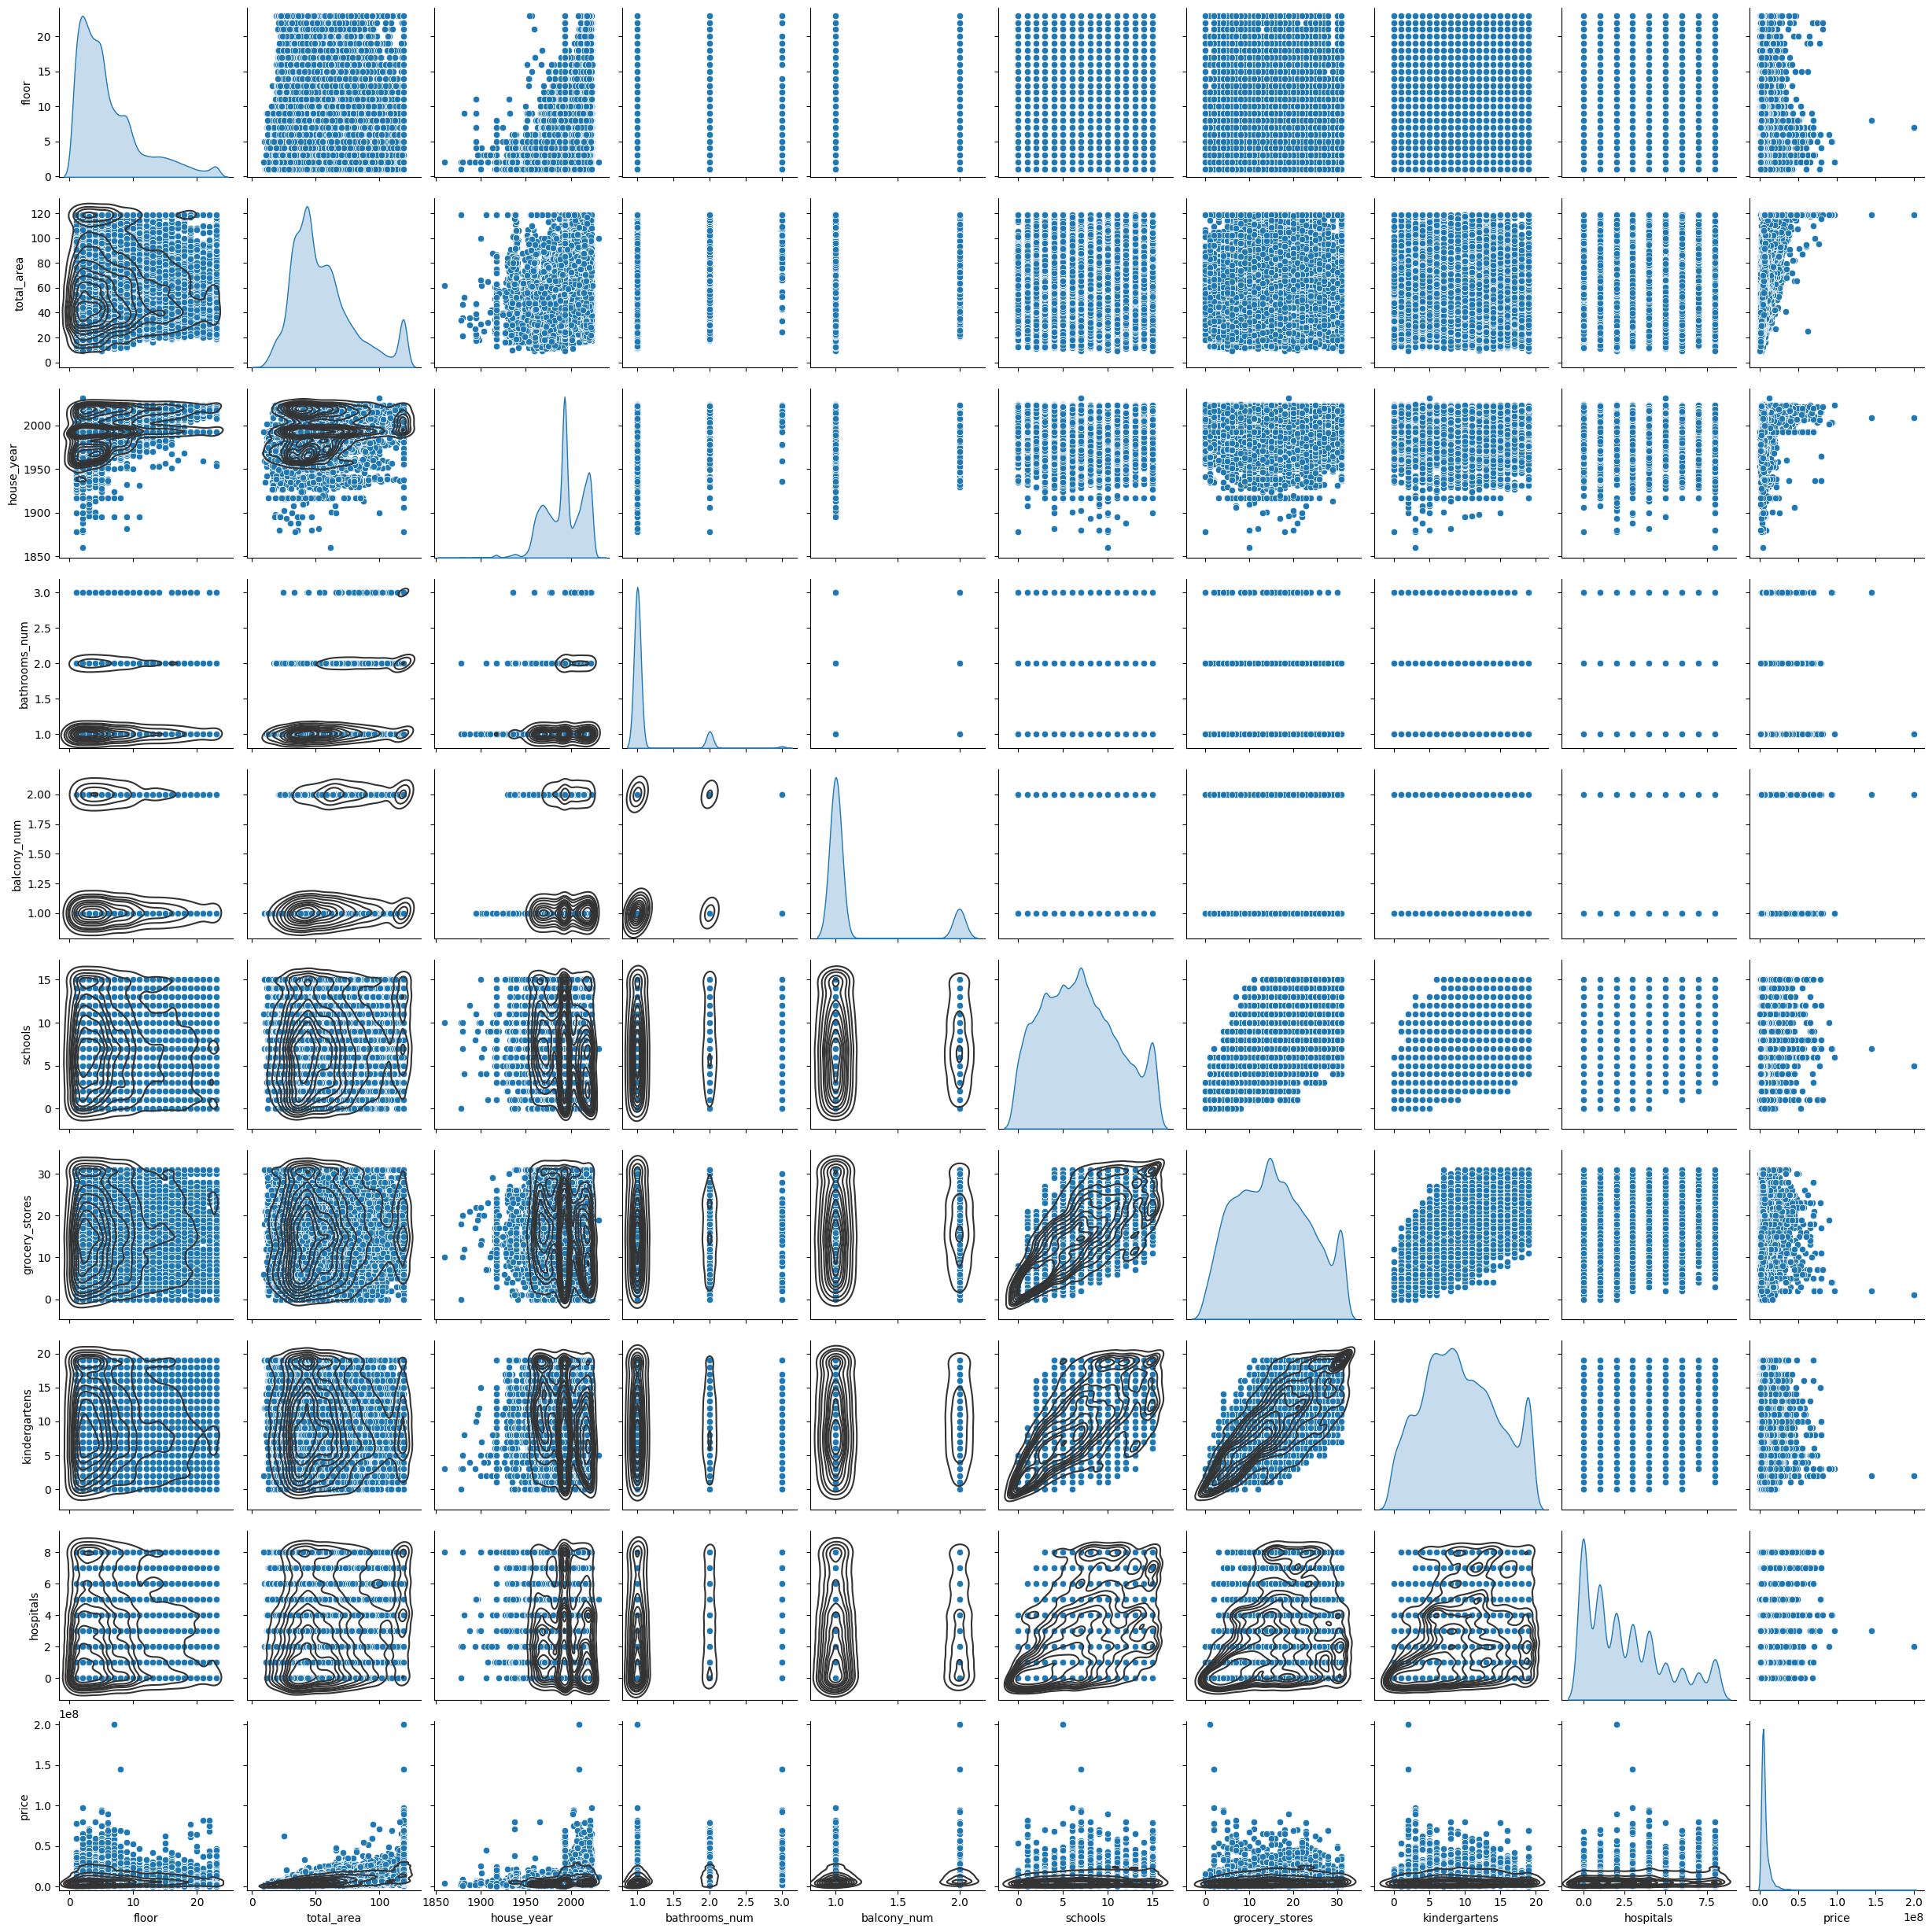

In [34]:
g = sns.pairplot(df[float_columns_filter + [target_name]], diag_kind="kde")
g.map_lower(sns.kdeplot, levels=10, color=".2")

## Предобработка данных

### Заполнение пропущенных значений

In [33]:
df_imputed = df.copy()

#### Заполнение пропущенных значений для категориальных признаков

Поскольку не все города могут иметь районы, используем значение 'Отсутствует' для явного указания на отсутствие информации, избегая предположений о неизвестных значениях.

In [34]:
df_imputed['city_district'] = df_imputed['city_district'].fillna('Отсутствует')

Для признаков 'repair' и 'house_type' используем моду, чтобы сохранить исходное распределение категорий.

In [35]:
df_imputed['repair'] = df_imputed['repair'].fillna(df_imputed['repair'].mode()[0])
df_imputed['house_type'] = df_imputed['house_type'].fillna(df_imputed['house_type'].mode()[0])

#### Заполнение пропущенных значений для числовых признаков

In [36]:
df_imputed['house_year'] = df_imputed['house_year'].fillna(df_imputed['house_year'].median())
df_imputed['bathrooms_num'] = df_imputed['bathrooms_num'].fillna(df_imputed['bathrooms_num'].median())
df_imputed['elevators_num'] = df_imputed['elevators_num'].fillna(df_imputed['elevators_num'].median())
df_imputed['balcony_num'] = df_imputed['balcony_num'].fillna(df_imputed['balcony_num'].median())

Таким образом, в результате проведенной серии операций по импутации и удалению столбцов с пропущенными значениями, в текущем DataFrame больше не осталось ни одной колонки с пропущенными значениями. Это означает, что все столбцы, которые ранее содержали пропуски, либо были полностью заполнены, либо удалены из анализа.

In [37]:
columns_with_miss = df_imputed.columns[df_imputed.isna().any(axis=0)]
df_imputed[columns_with_miss].info()

<class 'pandas.core.frame.DataFrame'>
Index: 32520 entries, 0 to 32660
Empty DataFrame


### Преобразование признаков

#### Преобразование целевой переменной

Исходное распределение цены было сильно скошено вправо, что могло затруднить работу многих алгоритмов машинного обучения. Для улучшения аналитических свойств данных было применено преобразование Бокса-Кокса, которое помогло стабилизировать дисперсию и сделать распределение ближе к нормальному. Это преобразование обычно включает логарифмическую коррекцию, уменьшая асимметрию распределения. В результате, преобразованное распределение стало более симметричным и менее скошенным, что улучшает условия для статистического моделирования и повышает точность прогнозов.

<Axes: xlabel='price_boxcox', ylabel='Count'>

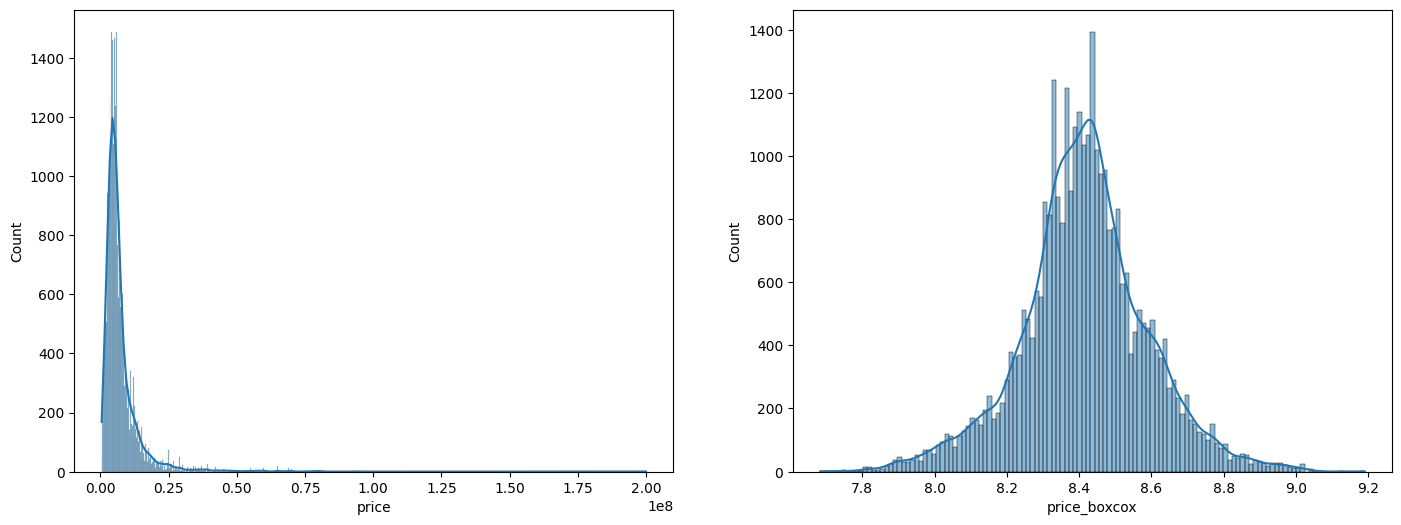

In [38]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (17,6))
sns.histplot(df[target_name], kde=True, ax=ax1)
df['price_boxcox'], boxcox_lambda = scipy.stats.boxcox(df[target_name])
df_imputed['price_boxcox'], boxcox_lambda = scipy.stats.boxcox(df[target_name])
sns.histplot(df['price_boxcox'], kde=True, ax=ax2)

In [39]:
boxcox_lambda

-0.08893272782359705

#### Преобразование числовых признаков

В этом разделе проводится логарифмическое преобразование некоторых числовых признаков в наборе данных для улучшения их распределения. Логарифмическое преобразование является распространенной техникой для работы с признаками, которые имеют сильное смещение влево или вправо. Цель такого преобразования — стабилизировать дисперсию, уменьшить влияние выбросов и привести распределение признаков к более симметричной форме, что способствует улучшению работы многих моделей машинного обучения.

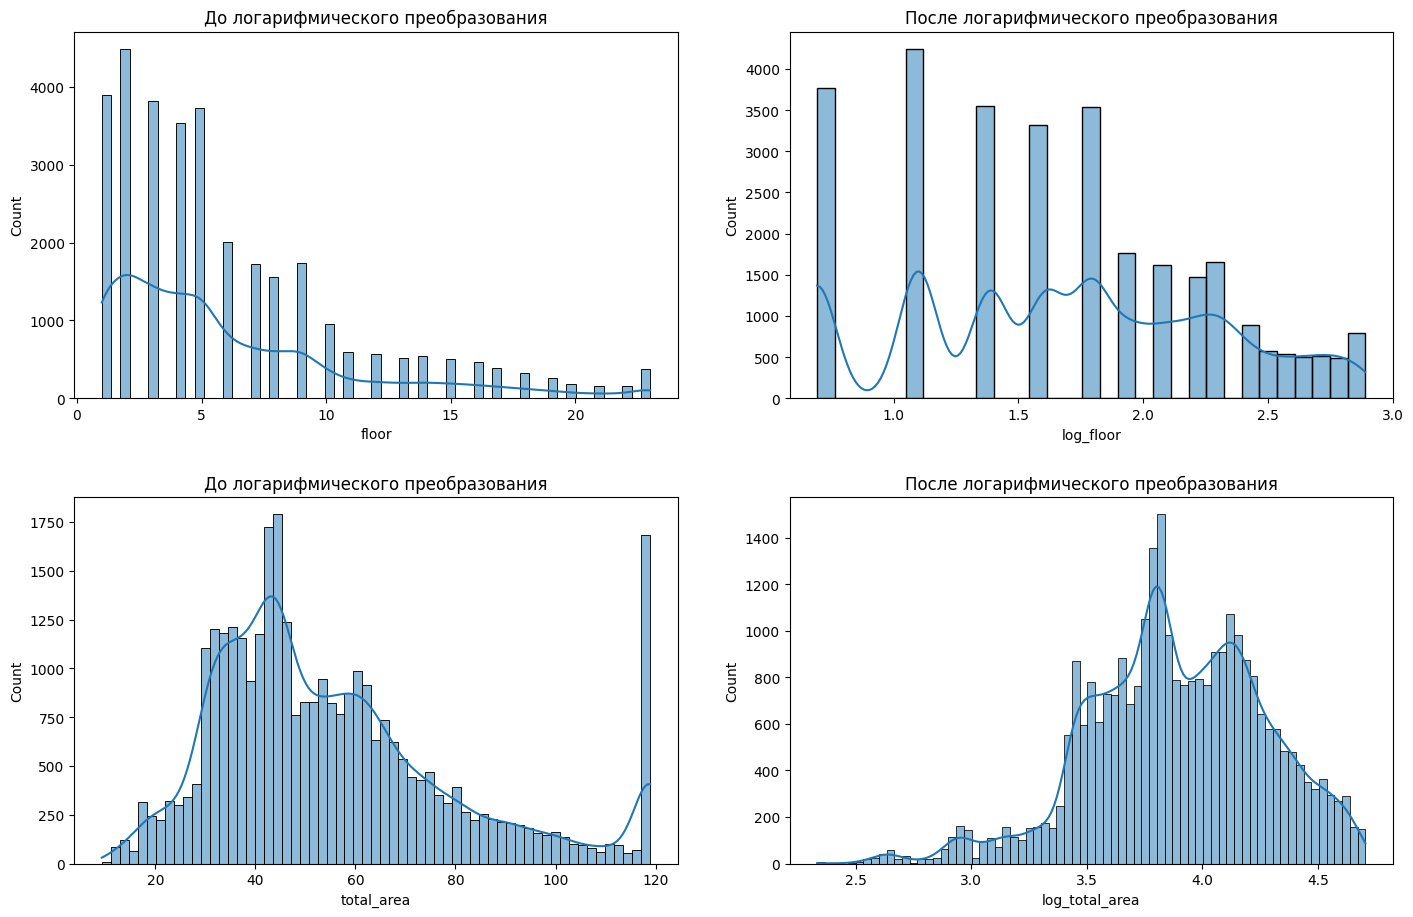

In [40]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

log_transform_cols = ['floor', 'total_area']

df_cleaned = df.copy()

for col in log_transform_cols:
    df_cleaned = remove_outliers(df_cleaned, col)

for col in log_transform_cols:
    df_cleaned[f'log_{col}'] = np.log1p(df_cleaned[col])

fig, axes = plt.subplots(len(log_transform_cols), 2, figsize=(15, 5 * len(log_transform_cols)))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(log_transform_cols):
    sns.histplot(df[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'До логарифмического преобразования')

    sns.histplot(df_cleaned[f'log_{feature}'], kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'После логарифмического преобразования')

plt.show()

In [41]:
for col in log_transform_cols:
    df_imputed[f'log_{col}'] = np.log1p(df_imputed[col])

## Разделение на обучающую и тестовую выборки

In [42]:
features = [
    'rooms', 'city', 'city_district', 'state', 'log_floor', 'housing_type',
    'house_type', 'repair', 'log_total_area', 'schools', 'grocery_stores',
    'kindergartens', 'hospitals'
]

In [43]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    df_imputed[features],
    df_imputed['price_boxcox'],
    test_size=0.2,
    random_state=42
)

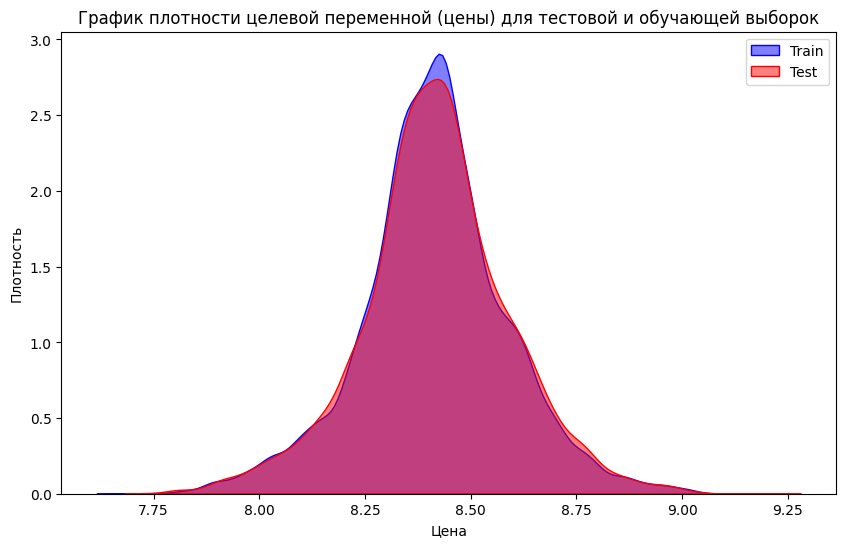

In [44]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_train, label='Train', fill=True, common_norm=False, color='blue', alpha=0.5)
sns.kdeplot(y_test, label='Test', fill=True, common_norm=False, color='red', alpha=0.5)
plt.title('График плотности целевой переменной (цены) для тестовой и обучающей выборок')
plt.xlabel('Цена' if 'boxcox' in y_train.name else 'Price')
plt.ylabel('Плотность')
plt.legend()
plt.show()

## Обучение различных моделей

### CatBoost

In [45]:
cat_features = ['rooms', 'city', 'city_district', 'state', 'housing_type', 'house_type', 'repair']

In [46]:
for feature in cat_features:
  df_imputed[feature] = df_imputed[feature].astype(str)

In [47]:
for feature in cat_features:
  X_train[feature] = X_train[feature].astype(str)
  X_test[feature] = X_test[feature].astype(str)

In [48]:
X = df_imputed[features]
y = df_imputed['price_boxcox']

In [52]:
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.1,
    depth=8,
    eval_metric='RMSE',
    cat_features=cat_features,
    early_stopping_rounds=10,
    random_seed=42
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1650183	test: 0.1666784	best: 0.1666784 (0)	total: 72.8ms	remaining: 2m 25s
10:	learn: 0.1130649	test: 0.1130236	best: 0.1130236 (10)	total: 171ms	remaining: 30.8s
20:	learn: 0.0963812	test: 0.0954783	best: 0.0954783 (20)	total: 255ms	remaining: 24s
30:	learn: 0.0898626	test: 0.0890024	best: 0.0890024 (30)	total: 343ms	remaining: 21.8s
40:	learn: 0.0855884	test: 0.0850218	best: 0.0850218 (40)	total: 432ms	remaining: 20.6s
50:	learn: 0.0822861	test: 0.0818582	best: 0.0818582 (50)	total: 521ms	remaining: 19.9s
60:	learn: 0.0795492	test: 0.0795379	best: 0.0795379 (60)	total: 625ms	remaining: 19.9s
70:	learn: 0.0771934	test: 0.0776537	best: 0.0776537 (70)	total: 731ms	remaining: 19.9s
80:	learn: 0.0756979	test: 0.0765000	best: 0.0765000 (80)	total: 808ms	remaining: 19.1s
90:	learn: 0.0738073	test: 0.0749563	best: 0.0749563 (90)	total: 901ms	remaining: 18.9s
100:	learn: 0.0719697	test: 0.0733102	best: 0.0733102 (100)	total: 994ms	remaining: 18.7s
110:	learn: 0.0708706	test: 0.07

In [53]:
y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

RMSE: 0.056571296317734894
MAE: 0.03719711720468918
R^2: 0.897392912336588


In [59]:
from catboost import Pool

features = [
    'rooms', 'city', 'city_district', 'state', 'log_floor', 'housing_type',
    'house_type', 'repair', 'log_total_area', 'schools', 'grocery_stores',
    'kindergartens', 'hospitals'
]

model_params = {
    'iterations': 2000,
    'learning_rate': 0.1,
    'depth': 8,
    'early_stopping_rounds': 10,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': False 
}

features = df_imputed[features]
labels = df_imputed['price_boxcox']

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_num = 1
scores = []

for train_index, test_index in kf.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = labels.iloc[train_index], labels.iloc[test_index]
    
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_test, y_test, cat_features=cat_features)
    
    model = CatBoostRegressor(**model_params)
    model.fit(train_pool, eval_set=val_pool)
    
    score = model.get_best_score()['validation']['RMSE']
    scores.append(score)
    
    print(f"Fold {fold_num}: RMSE = {score}")
    fold_num += 1

average_rmse = np.mean(scores)
print(f"Average RMSE across all folds: {average_rmse}")

Fold 1: RMSE = 0.05521910927819756
Fold 2: RMSE = 0.05932518389625782
Fold 3: RMSE = 0.05966270102389594
Fold 4: RMSE = 0.055943464158575436
Fold 5: RMSE = 0.059403060675665996
Average RMSE across all folds: 0.05791070380651855


In [60]:
validation_pool = Pool(X_test, y_test, cat_features=cat_features)
params = {
    'iterations': [1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}
model = CatBoostRegressor(cat_features=cat_features, eval_metric='RMSE', verbose=False, random_seed=42, early_stopping_rounds=10)

grid_search = GridSearchCV(model, params, cv=3, scoring='neg_root_mean_squared_error', verbose=10)
grid_search.fit(X_train, y_train, eval_set=validation_pool)

print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3; 1/27] START depth=4, iterations=1000, learning_rate=0.01...............
[CV 1/3; 1/27] END depth=4, iterations=1000, learning_rate=0.01;, score=-0.125 total time=   2.5s
[CV 2/3; 1/27] START depth=4, iterations=1000, learning_rate=0.01...............
[CV 2/3; 1/27] END depth=4, iterations=1000, learning_rate=0.01;, score=-0.103 total time=   3.4s
[CV 3/3; 1/27] START depth=4, iterations=1000, learning_rate=0.01...............
[CV 3/3; 1/27] END depth=4, iterations=1000, learning_rate=0.01;, score=-0.120 total time=   3.6s
[CV 1/3; 2/27] START depth=4, iterations=1000, learning_rate=0.05...............
[CV 1/3; 2/27] END depth=4, iterations=1000, learning_rate=0.05;, score=-0.127 total time=   1.8s
[CV 2/3; 2/27] START depth=4, iterations=1000, learning_rate=0.05...............
[CV 2/3; 2/27] END depth=4, iterations=1000, learning_rate=0.05;, score=-0.105 total time=   1.3s
[CV 3/3; 2/27] START depth=4, iterations=100

In [61]:
best_model = grid_search.best_estimator_

In [62]:
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

RMSE: 0.06576318265513686
MAE: 0.044545448117200556
R^2: 0.8560000772476855


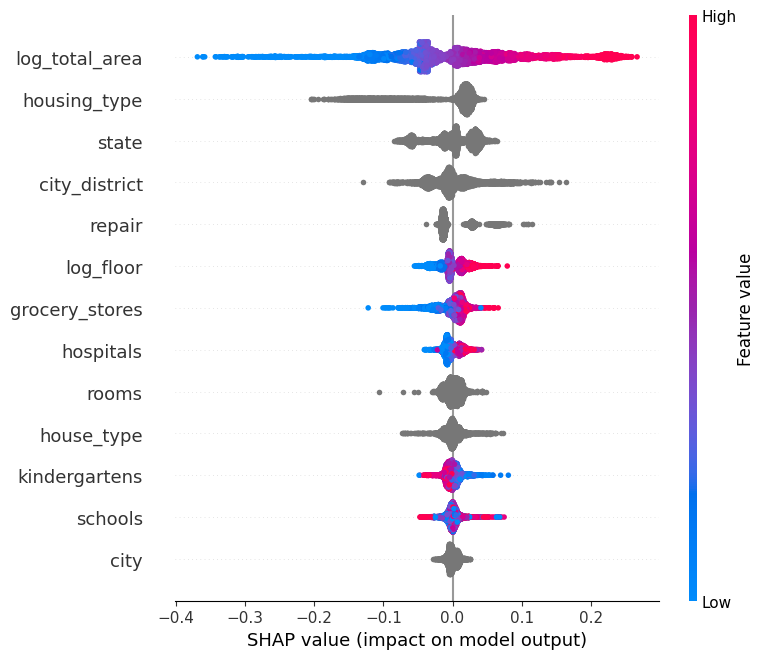

In [63]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
plt.show()

In [64]:
features_reduced = [
    'rooms', 'city_district', 'state', 'log_floor', 'housing_type', 
    'repair', 'log_total_area', 'schools', 'grocery_stores',
    'kindergartens', 'hospitals'
]
X_train_reduced = X_train.drop(['city', 'house_type'], axis=1)
X_test_reduced = X_test.drop(['city', 'house_type'], axis=1)

best_model_reduced = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.1,
    depth=8,
    cat_features = ['rooms', 'city_district', 'state', 'housing_type', 'repair'],
    eval_metric='RMSE',
    verbose=100
)

best_model_reduced.fit(X_train_reduced, y_train, eval_set=(X_test_reduced, y_test), verbose=100, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1655760	test: 0.1633230	best: 0.1633230 (0)	total: 35.5ms	remaining: 53.2s
100:	learn: 0.0737336	test: 0.0774233	best: 0.0774233 (100)	total: 852ms	remaining: 11.8s
200:	learn: 0.0652745	test: 0.0711753	best: 0.0711753 (200)	total: 2.01s	remaining: 13s
300:	learn: 0.0599611	test: 0.0677645	best: 0.0677645 (300)	total: 2.81s	remaining: 11.2s
400:	learn: 0.0560436	test: 0.0657912	best: 0.0657886 (399)	total: 3.83s	remaining: 10.5s
500:	learn: 0.0530552	test: 0.0645418	best: 0.0645418 (500)	total: 4.6s	remaining: 9.18s
600:	learn: 0.0509250	test: 0.0637216	best: 0.0637173 (598)	total: 5.43s	remaining: 8.12s
700:	learn: 0.0487702	test: 0.0629290	best: 0.0629290 (700)	total: 6.43s	remaining: 7.33s
800:	learn: 0.0471817	test: 0.0625064	best: 0.0625064 (800)	total: 7.47s	remaining: 6.52s
900:	learn: 0.0456843	test: 0.0620640	best: 0.0620639 (899)	total: 8.33s	remaining: 5.54s
1000:	learn: 0.0444070	test: 0.0617626	best: 0.0617330 (994)	total: 9.37s	remaining: 4.67s
1100:	learn: 0.

In [65]:
y_pred = best_model_reduced.predict(X_test_reduced)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

RMSE: 0.06050465987317563
MAE: 0.03833123549734797
R^2: 0.8781082644243184


### LightGBM

In [49]:
features = [
    'rooms', 'city', 'city_district', 'state', 'log_floor', 'housing_type',
    'house_type', 'repair', 'log_total_area', 'schools', 'grocery_stores',
    'kindergartens', 'hospitals'
]

In [50]:
cat_features = ['rooms', 'city', 'city_district', 'state', 'housing_type', 'house_type', 'repair']

In [56]:
for feature in cat_features:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')

In [57]:
for feature in cat_features:
  df_imputed[feature] = df_imputed[feature].astype('category')

In [58]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [59]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, free_raw_data=False)

In [60]:
cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=5000,
    nfold=5,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)],
    stratified=False
)

Training until validation scores don't improve for 50 rounds
[50]	cv_agg's valid rmse: 0.0803288 + 0.00106767
[100]	cv_agg's valid rmse: 0.0733118 + 0.00127702
[150]	cv_agg's valid rmse: 0.0697603 + 0.00126955
[200]	cv_agg's valid rmse: 0.0677588 + 0.00122878
[250]	cv_agg's valid rmse: 0.0662226 + 0.00119676
[300]	cv_agg's valid rmse: 0.0651347 + 0.00122235
[350]	cv_agg's valid rmse: 0.0642375 + 0.00120563
[400]	cv_agg's valid rmse: 0.0635197 + 0.00110195
[450]	cv_agg's valid rmse: 0.0629182 + 0.00112246
[500]	cv_agg's valid rmse: 0.0624006 + 0.00113221
[550]	cv_agg's valid rmse: 0.0619173 + 0.00113665
[600]	cv_agg's valid rmse: 0.061534 + 0.00114805
[650]	cv_agg's valid rmse: 0.0611956 + 0.00116435
[700]	cv_agg's valid rmse: 0.0609166 + 0.00112838
[750]	cv_agg's valid rmse: 0.0605595 + 0.00112349
[800]	cv_agg's valid rmse: 0.0603402 + 0.00111215
[850]	cv_agg's valid rmse: 0.0601182 + 0.00106851
[900]	cv_agg's valid rmse: 0.0599071 + 0.00104012
[950]	cv_agg's valid rmse: 0.0597005 + 0.

In [61]:
best_n_estimators = len(cv_results['valid rmse-mean'])
print(cv_results['valid rmse-mean'][-1])

0.05815548334643541


In [62]:
gbm = lgb.train(params, train_data, num_boost_round=best_n_estimators, valid_sets=[train_data, test_data])

In [70]:
from sklearn.metrics import root_mean_squared_error

y_pred = gbm.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

RMSE: 0.06159314776933589
MAE: 0.031071197241563295
R^2: 0.878367237109646


In [71]:
X = df_imputed[features]
y = df_imputed['price_boxcox']

In [ ]:
kf = KFold(n_splits=5)
fold_results = []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold, categorical_feature=cat_features)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)

    gbm = lgb.train(params, train_data, num_boost_round=best_n_estimators, valid_sets=[val_data])
    
    y_pred = gbm.predict(X_val_fold)
    rmse = root_mean_squared_error(y_val_fold, y_pred)
    
    fold_results.append(rmse)
    print(f'Fold RMSE: {rmse}')

average_rmse = np.mean(fold_results)
print(f'Average RMSE: {average_rmse}')

Fold RMSE: 0.15036341943394424


### RandomForest

In [146]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[cat_features])
X_test_encoded = encoder.transform(X_test[cat_features])

In [147]:
encoded_cat_features = encoder.get_feature_names_out(cat_features)

In [148]:
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cat_features, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cat_features, index=X_test.index)

In [149]:
X_train_full = pd.concat([X_train_encoded_df, X_train.drop(columns=cat_features)], axis=1)
X_test_full = pd.concat([X_test_encoded_df, X_test.drop(columns=cat_features)], axis=1)

In [150]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_full, y_train)

RandomForestRegressor(random_state=42)

In [151]:
y_pred_rf = rf_model.predict(X_test_full)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'RandomForest RMSE: {rmse_rf}')
print(f'RandomForest MAE: {mae_rf}')
print(f'RandomForest R^2: {r2_rf}')

RandomForest RMSE: 0.06097576307771344
RandomForest MAE: 0.03586616354834014
RandomForest R^2: 0.8762027204880593


In [152]:
X_full_encoded = encoder.fit_transform(df_imputed[cat_features])
X_full_encoded_df = pd.DataFrame(X_full_encoded, columns=encoder.get_feature_names_out(cat_features))
X_full = pd.concat([X_full_encoded_df, df_imputed[features].drop(columns=cat_features).reset_index(drop=True)], axis=1)
y_full = df_imputed['price_boxcox']

In [154]:
cv_rmse_rf = -cross_val_score(rf_model, X_full, y_full, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f'RandomForest Cross-validated RMSE: {cv_rmse_rf}')

RandomForest Cross-validated RMSE: 0.11843460977931744
